In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn import tree
import xgboost as xgb
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_tree

import gc
from tqdm import tqdm

from matplotlib.ticker import FuncFormatter

In [2]:
column_defs = pd.read_excel('data\LCDataDictionary.xlsx',index_col='LoanStatNew')
column_defs.columns

Index(['Description'], dtype='object')

In [3]:
def plot_cats(column):
    loan_statuses = ['Fully Paid','Charged Off']
    g = df.groupby(column)['loan_status'].value_counts(normalize=True).unstack()
    list_dfs = []
    for status in loan_statuses:
        vals = g[status].values
        idx = g[status].index
        frame = pd.DataFrame(data=vals,index=idx,columns=['value_counts']).reset_index().rename(columns={'index':column})
        frame['loan_status'] = status
        list_dfs.append(frame)
    comb = pd.concat([list_dfs[0],list_dfs[1]])
    num = df[column].nunique()
    fig, (ax,ax1) = plt.subplots(1,2,figsize=(15,8))
    sns.histplot(x=column, data=df.sort_values(column),bins=(num/4),ax=ax)
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    ax.set_title(column + ' Histplot')
    sns.despine()
    sns.barplot(x=column,y='value_counts',hue='loan_status',data=comb,ax=ax1)
    ax1.set_xlabel(column)
    ax1.set_ylabel('% of Total Loans')
    ax1.set_title(column + ' by Loan Status')
    plt.tight_layout()

In [4]:
def na_check(data):
    check = np.round(data.isna().mean().sort_values(ascending=False),2)
    return check

In [5]:
def column_info(col_name):
    return column_defs.loc[col_name]['Description']

In [6]:
def reduce_mem_usage(df, int_cast=True, obj_to_category=False, subset=None):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.
    :param df: dataframe to reduce (pd.DataFrame)
    :param int_cast: indicate if columns should be tried to be casted to int (bool)
    :param obj_to_category: convert non-datetime related objects to category dtype (bool)
    :param subset: subset of columns to analyse (list)
    :return: dataset with the column dtypes adjusted (pd.DataFrame)
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2;
    gc.collect()
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    cols = subset if subset is not None else df.columns.tolist()

    for col in tqdm(cols):
        col_type = df[col].dtype

        if col_type != object and col_type.name != 'category' and 'datetime' not in col_type.name:
            c_min = df[col].min()
            c_max = df[col].max()

            # test if column can be converted to an integer
            treat_as_int = str(col_type)[:3] == 'int'
            if int_cast and not treat_as_int:
                treat_as_int = check_if_integer(df[col])

            if treat_as_int:
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                    df[col] = df[col].astype(np.uint8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                    df[col] = df[col].astype(np.uint16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                    df[col] = df[col].astype(np.uint32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                    df[col] = df[col].astype(np.uint64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif 'datetime' not in col_type.name and obj_to_category:
            df[col] = df[col].astype('category')
    gc.collect()
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.3f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [7]:
df = pd.read_csv('data/preprocessed.csv')

In [8]:
df.drop(columns=['Unnamed: 0','Unnamed: 0.1'],axis=1,inplace=True)

In [9]:
reduce_mem_usage(df,int_cast=False)

  0%|          | 0/75 [00:00<?, ?it/s]

Memory usage of dataframe is 993.88 MB


100%|██████████| 75/75 [00:10<00:00,  6.88it/s]


Memory usage after optimization is: 637.742 MB
Decreased by 35.8%


,id,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10129454,12000.0,36 months,10.99%,392.799988,B,B2,4,RENT,60000.0,...,0.0,4.0,100.000000,0.0,0.0,7137.0,18100.0,0.0,N,N
1,10149488,4800.0,36 months,10.99%,157.100006,B,B2,2,MORTGAGE,39600.0,...,0.0,0.0,100.000000,0.0,0.0,4136.0,25700.0,0.0,N,N
2,10149342,27060.0,36 months,10.99%,885.500000,B,B2,10,OWN,55000.0,...,0.0,1.0,100.000000,0.0,0.0,70186.0,35700.0,33054.0,N,N
3,10148122,12000.0,36 months,7.62%,374.000000,A,A3,3,MORTGAGE,96500.0,...,0.0,3.0,100.000000,0.0,0.0,46738.0,14800.0,53404.0,N,N
4,10129477,14000.0,36 months,12.85%,470.799988,B,B4,4,RENT,88000.0,...,0.0,0.0,78.599998,1.0,0.0,17672.0,3900.0,27340.0,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1736932,102556443,24000.0,60 months,23.99%,690.500000,E,E2,1,RENT,107000.0,...,1.0,2.0,87.500000,1.0,1.0,60812.0,28200.0,64422.0,N,N
1736933,102653304,10000.0,36 months,7.99%,313.200012,A,A5,10,MORTGAGE,65000.0,...,0.0,2.0,92.599998,0.0,0.0,55863.0,34800.0,70203.0,N,N
1736934,102628603,10050.0,36 months,16.99%,358.200012,D,D1,8,RENT,37000.0,...,0.0,5.0,95.199997,0.0,0.0,14300.0,9000.0,0.0,N,N
1736935,102196576,6000.0,36 months,11.44%,197.800003,B,B4,5,RENT,41000.0,...,0.0,1.0,94.400002,0.0,0.0,26201.0,8100.0,34076.0,N,N



# Feature Inspection  and EDA

I've imported my preprocessed data which has dealt with null values in our data. Going through our feature inspection, I will append the list below for features that our inspection & EDA find's to be unimportant

In [10]:
features_to_drop = []

In [11]:
#Shows to 5 most recurring values for each feature.
for col in df.columns:
    print(col)
    print(column_info(col))
    print(df[col].value_counts(normalize = True, ascending=False).head(5))
    print("-------------------------------------------------------------")

id
A unique LC assigned ID for the loan listing.
4196351      5.757261e-07
75101579     5.757261e-07
137966995    5.757261e-07
62459284     5.757261e-07
68525187     5.757261e-07
Name: id, dtype: float64
-------------------------------------------------------------
loan_amnt
The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
10000.0    0.078220
20000.0    0.054624
12000.0    0.053229
15000.0    0.053078
35000.0    0.037777
Name: loan_amnt, dtype: float64
-------------------------------------------------------------
term
The number of payments on the loan. Values are in months and can be either 36 or 60.
 36 months    0.748299
 60 months    0.251701
Name: term, dtype: float64
-------------------------------------------------------------
int_rate
Interest Rate on the loan
  5.32%    0.023535
 10.99%    0.023520
 11.99%    0.023327
 13.99%    0.020804
 11.49%    0.0165

10838.354492    0.000242
16257.527344    0.000180
21676.718750    0.000169
11258.436523    0.000164
11784.232422    0.000162
Name: total_pymnt, dtype: float64
-------------------------------------------------------------
total_rec_prncp
Principal received to date
10000.0    0.063263
12000.0    0.043437
20000.0    0.042911
15000.0    0.042768
5000.0     0.031389
Name: total_rec_prncp, dtype: float64
-------------------------------------------------------------
total_rec_int
Interest received to date
1258.0    0.000657
2096.0    0.000532
2070.0    0.000472
2146.0    0.000471
2078.0    0.000468
Name: total_rec_int, dtype: float64
-------------------------------------------------------------
total_rec_late_fee
Late fees received to date
0.0     0.949528
15.0    0.011833
30.0    0.002365
45.0    0.000838
60.0    0.000357
Name: total_rec_late_fee, dtype: float64
-------------------------------------------------------------
recoveries
post charge off gross recovery
0.0      0.858990
150.0    

Name: pub_rec_bankruptcies, dtype: float64
-------------------------------------------------------------
tax_liens
Number of tax liens
0.0    0.968446
1.0    0.021345
2.0    0.005909
3.0    0.002182
4.0    0.000983
Name: tax_liens, dtype: float64
-------------------------------------------------------------
total_bal_ex_mort
Total credit balance excluding mortgage
0.0        0.000511
19095.0    0.000028
21168.0    0.000027
25529.0    0.000027
16053.0    0.000027
Name: total_bal_ex_mort, dtype: float64
-------------------------------------------------------------
total_bc_limit
Total bankcard high credit/credit limit
5000.0     0.007954
6000.0     0.007106
10000.0    0.006792
7000.0     0.006772
8000.0     0.006571
Name: total_bc_limit, dtype: float64
-------------------------------------------------------------
total_il_high_credit_limit
Total installment high credit/credit limit
0.0        0.119217
10000.0    0.005989
15000.0    0.004659
20000.0    0.003777
5000.0     0.003667
Name: t

Going through this check we found payment plan and outstanding principal had only 1 value so not providing any insight for us.
Also ID is unique to each loan so will not unlock any information for us either

In [12]:
for feature in ['id','pymnt_plan','out_prncp']:
    features_to_drop.append(feature)

In [13]:
#converting our issue_date to datetime so we can evaluate loans at origination overtime
df.issue_d = pd.to_datetime(df.issue_d)

In [ ]:
#df_cont_z = df[(np.abs(stats.zscore(df[cont_columns]))<4).all(axis=1)]

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1736937 entries, 0 to 1736936
Data columns (total 75 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   id                          int32         
 1   loan_amnt                   float32       
 2   term                        object        
 3   int_rate                    object        
 4   installment                 float32       
 5   grade                       object        
 6   sub_grade                   object        
 7   emp_length                  int8          
 8   home_ownership              object        
 9   annual_inc                  float32       
 10  verification_status         object        
 11  issue_d                     datetime64[ns]
 12  loan_status                 object        
 13  pymnt_plan                  object        
 14  url                         object        
 15  purpose                     object        
 16  title             

## Loan Amount

In [17]:
print('Loan Amount:\n{}'.format(column_info('loan_amnt')))

Loan Amount:
The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.


In [18]:
df.loan_amnt.value_counts()

10000.0    135864
20000.0     94879
12000.0     92455
15000.0     92193
35000.0     65617
            ...  
39330.0         3
39230.0         3
36770.0         3
35680.0         2
37980.0         1
Name: loan_amnt, Length: 1498, dtype: int64

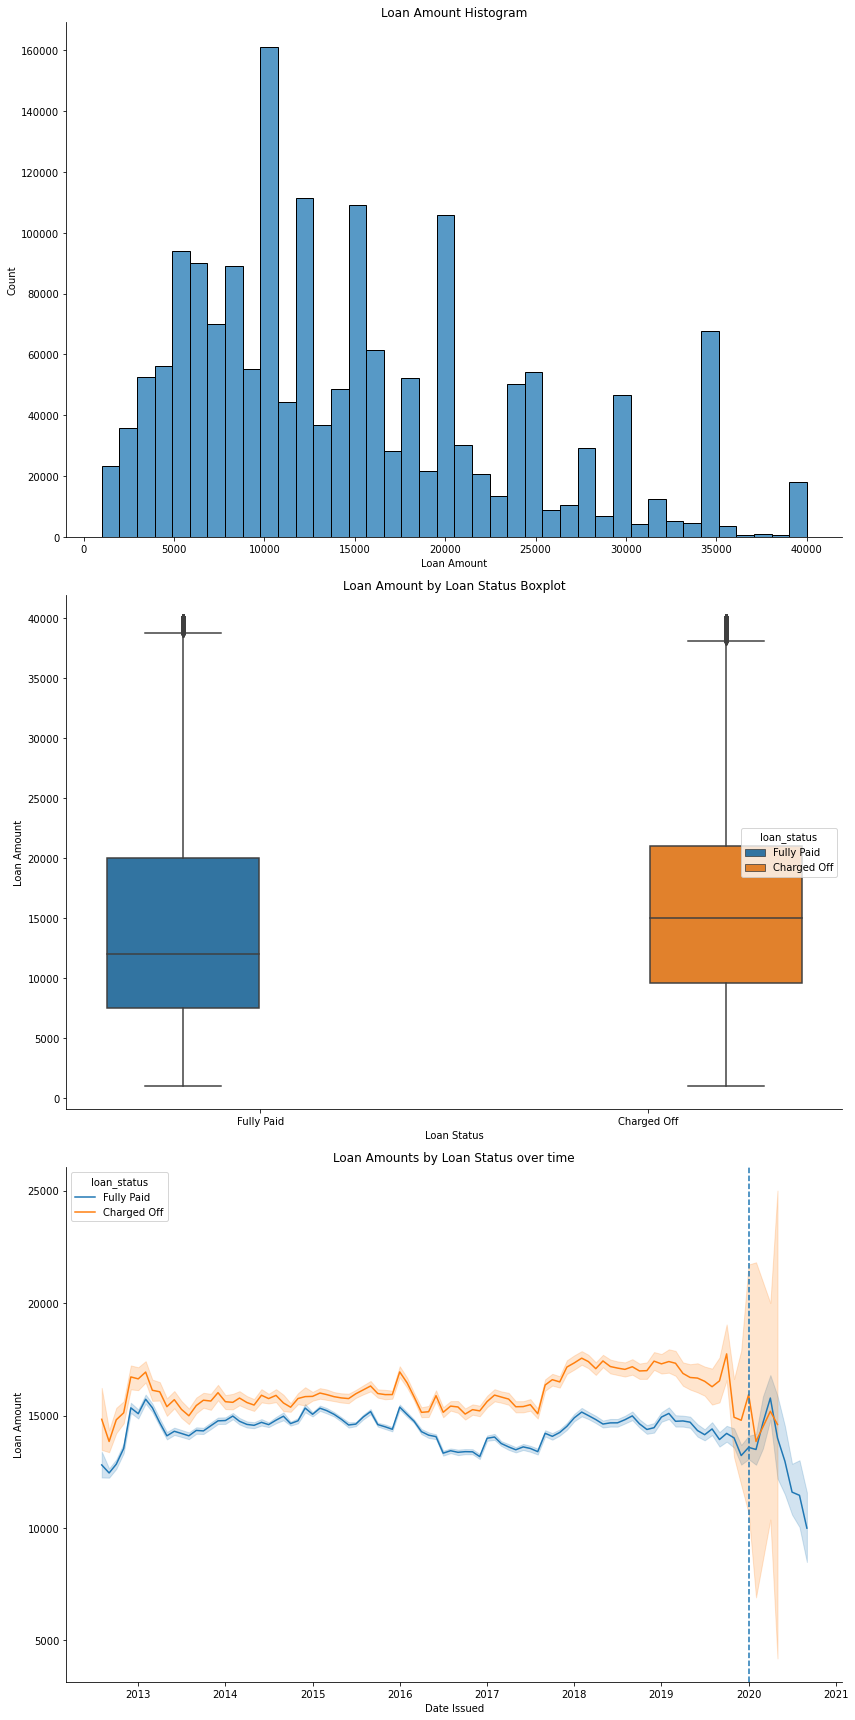

In [103]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,24))
sns.histplot(x='loan_amnt',data=df,bins=40,ax=ax1)
ax1.set_xlabel('Loan Amount')
ax1.set_ylabel('Count')
ax1.set_title('Loan Amount Histogram')

sns.despine()
sns.boxplot(x='loan_status' ,y='loan_amnt',hue='loan_status',data=df,ax=ax2)
ax2.set_xlabel('Loan Status')
ax2.set_ylabel('Loan Amount')
ax2.set_title('Loan Amount by Loan Status Boxplot')




sns.lineplot(x='issue_d' ,y='loan_amnt',hue='loan_status',data=df,ax=ax3)
ax3.set_xlabel('Date Issued')
ax3.set_ylabel('Loan Amount')
ax3.set_title('Loan Amounts by Loan Status over time')
ax3.axvline(x='2020',linestyle='--')
plt.tight_layout()
plt.savefig('images/loan_amount.png')


From our histogram we can see that loans are generally issued at increment of $5000

Our Boxplot shows u that loans that were charged off on average had higher loan amounts also represented in the final chart over time.

Also, our last graph shows us unsurprisingly that during covid loan amounts across both groups were reduced.

## Grade, SubGrade

In [22]:
df.sub_grade.value_counts()

C1    111249
B5    108420
B4    108080
B3    101337
C2    101066
C3     98078
C4     97457
B1     96292
B2     95881
C5     89676
A5     82978
A4     70457
D1     65042
A1     63754
D2     59184
A3     53336
A2     51599
D3     50195
D4     44203
D5     37361
E1     27161
E2     24135
E3     21158
E4     17949
E5     17352
F1     10737
F2      7502
F3      6385
F4      5030
F5      4176
G1      3236
G2      2202
G3      1696
G4      1341
G5      1232
Name: sub_grade, dtype: int64

In [23]:
df.grade.value_counts()

B    510010
C    497526
A    322124
D    255985
E    107755
F     33830
G      9707
Name: grade, dtype: int64

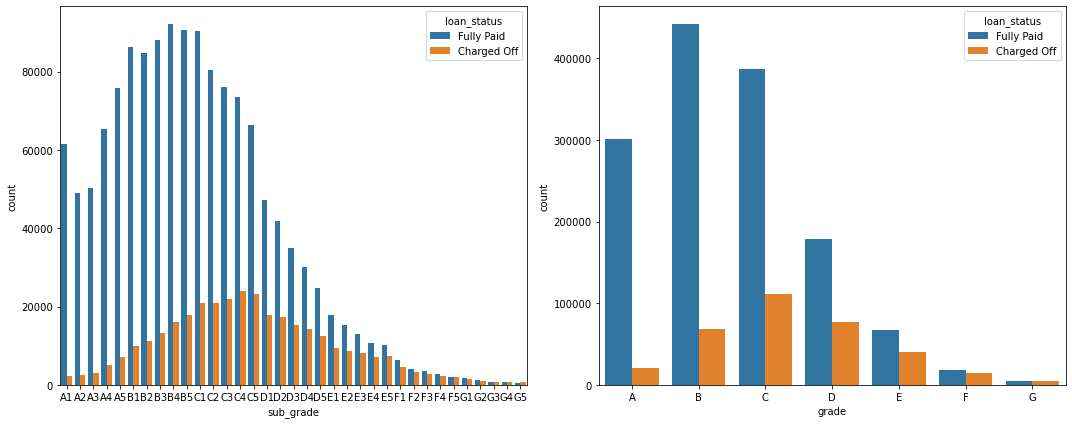

In [24]:
fig,(ax,ax1) = plt.subplots(1,2 ,figsize=(15,6))
sns.countplot(x='sub_grade',hue='loan_status',data=df.sort_values('sub_grade'),ax=ax)

sns.countplot(x='grade',hue='loan_status',data=df.sort_values('grade'),ax=ax1)
plt.tight_layout()

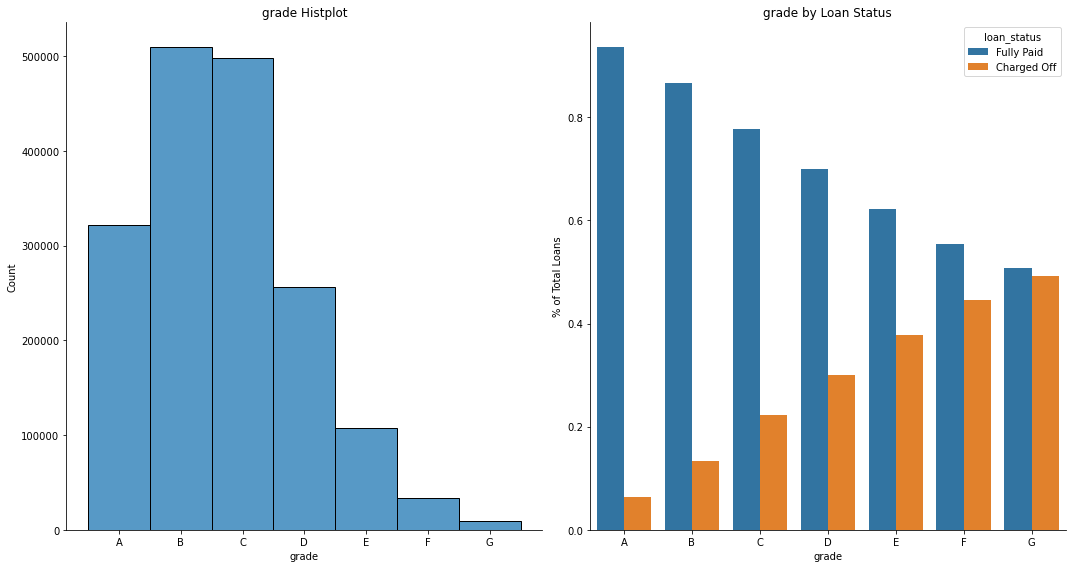

In [104]:
plot_cats('grade')
plt.savefig('grade.png')

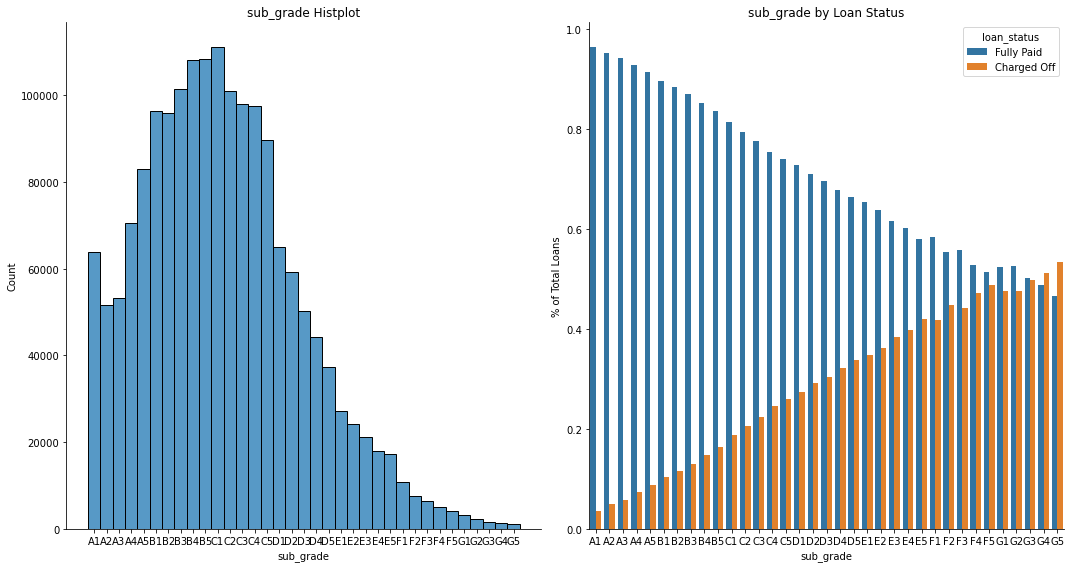

In [105]:
plot_cats('sub_grade')
plt.savefig('sub_grade.png')

Can see Sub_Grade and Grade both increase the probability of charge of the worst the credit grade, as we would suspect 

Sub grade corresponds to grade levels but is more granular, we will keep both for now as our modeling will may overfit with more categorical variables

## Fico Score

As we have both fico range high and low will first average them and drop the range boundaries

In [31]:
# making average fico score and dropping the fico range high and low
df['average_fico'] = (df['fico_range_high'] + df['fico_range_low'])/2
df.drop(columns=['fico_range_high','fico_range_low'],axis=1,inplace=True)

In [32]:
def continuous_plot(feature):
    fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,24))
    sns.histplot(x=feature,data=df,bins=40,ax=ax1)
    ax1.set_xlabel(feature)
    ax1.set_ylabel('Count')
    ax1.set_title('{} Histogram'.format(feature))

    sns.despine()
    sns.boxplot(x='loan_status' ,y=feature,hue='loan_status',data=df,ax=ax2)
    ax2.set_xlabel('Loan Status')
    ax2.set_ylabel(feature)
    ax2.set_title('{} by Loan Status Boxplot'.format(feature))

    sns.lineplot(x='issue_d' ,y=feature,hue='loan_status',data=df,ax=ax3)
    ax3.set_xlabel('Date Issued')
    ax3.set_ylabel(feature)
    ax3.set_title('{} by Loan Status over time'.format(feature))
    ax3.axvline(x='2020',linestyle='--')
    plt.tight_layout()

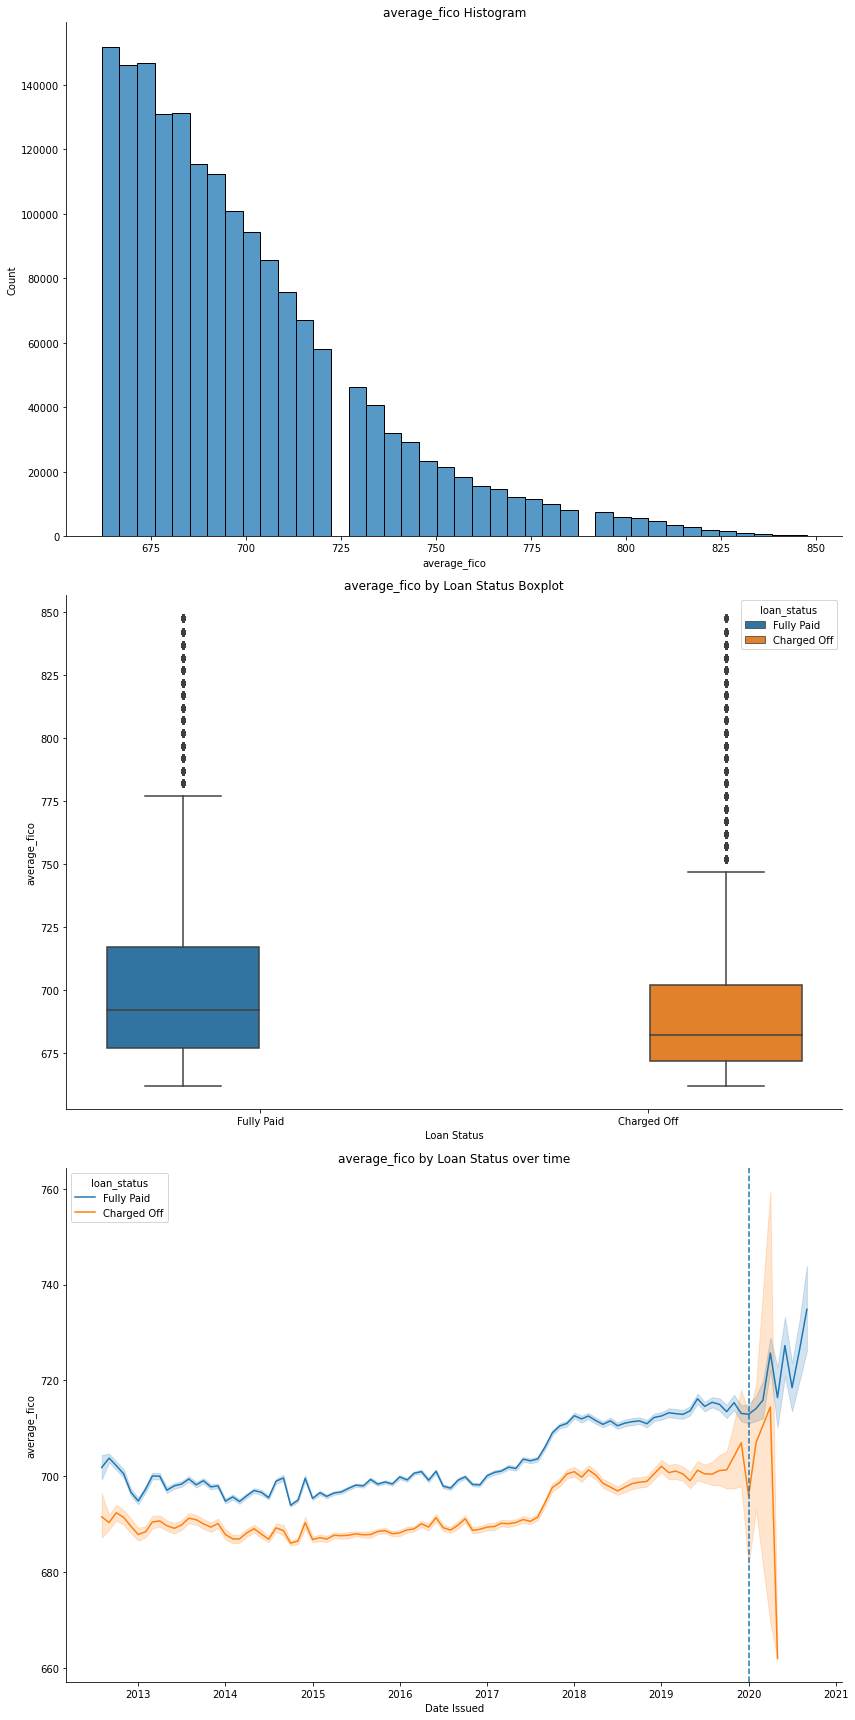

In [106]:
continuous_plot('average_fico')
plt.savefig('fico_score.png')

So interestingly, more loans were issued to applicants with lower fico scores, specifically below 725
But, as suspected the higher mean fico score was higher for loans that were fully paid off

This can be seen overtime as well, but additionally, the pandemic seemed to accentuate these relationships showing that average fico scores diverged sharply for fully paid and charged off loans

## Term

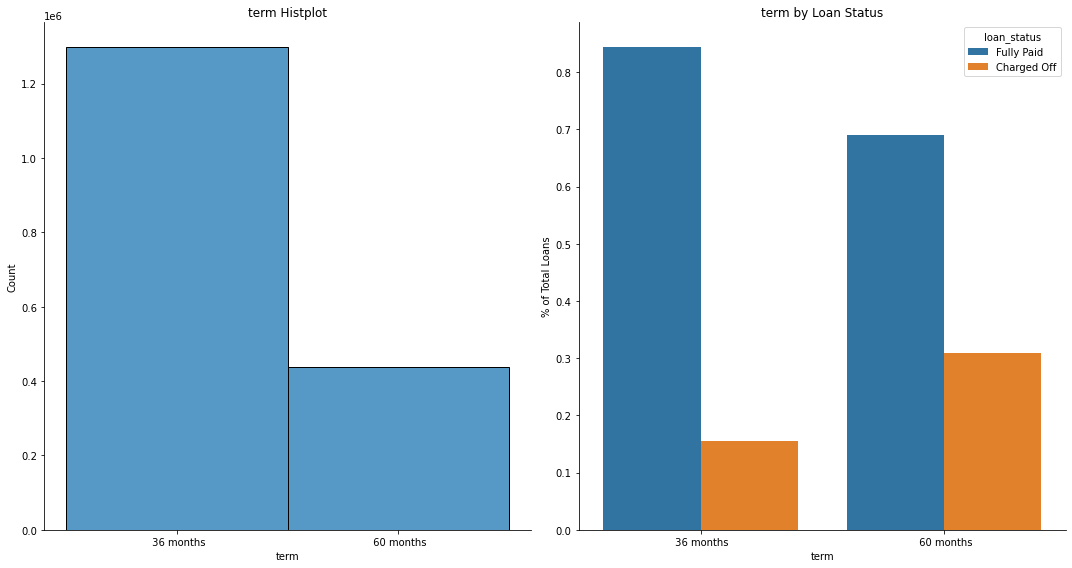

In [107]:
plot_cats('term')
plt.savefig('term.png')

In [35]:
df[df.term == ' 60 months']['loan_status'].value_counts(normalize=True)

Fully Paid     0.690241
Charged Off    0.309759
Name: loan_status, dtype: float64

In [36]:
df[df.term == ' 36 months']['loan_status'].value_counts(normalize=True)

Fully Paid     0.844838
Charged Off    0.155162
Name: loan_status, dtype: float64

Loans are either issued at 36 or 60 month terms, but there are more than double the amount of 36 month loans compared to 60 month ones

Loans over longer time horizons (60 months) have double the percentage of charge offs increasing from 15% to 31%

## Home Ownership

In [125]:
column_info('home_ownership')

'The home ownership status provided by the borrower during registration\xa0or obtained from the credit report.\xa0Our values are: RENT, OWN, MORTGAGE, OTHER'

In [37]:
df.home_ownership.value_counts()

MORTGAGE    860991
RENT        681150
OWN         193574
ANY           1133
NONE            45
OTHER           44
Name: home_ownership, dtype: int64

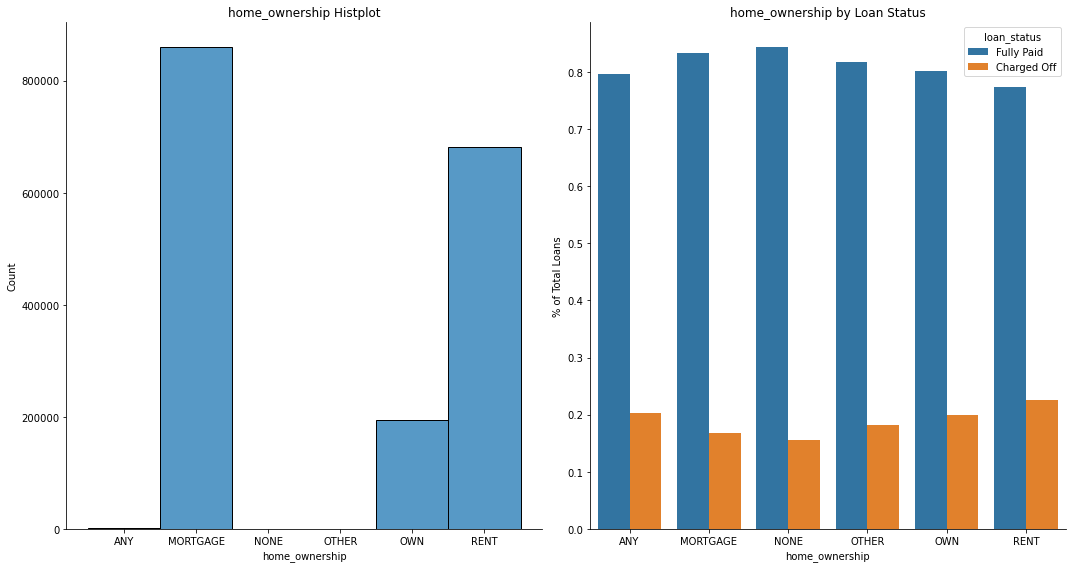

In [124]:
plot_cats('home_ownership')
plt.savefig('home.png')

For our home ownership feature most of the loans go to either applicants who have an existing mortgage or rent, followed by applicants who own their home.

Renters have the highest rate of charge offs across types of home ownership but the change is only a 5 % increase

## Title and Purpose

In [39]:
column_info('title')

'The loan title provided by the borrower'

In [40]:
df['title'].value_counts()

Debt consolidation            921572
Credit card refinancing       361407
Home improvement              107869
Other                          98205
Major purchase                 35205
                               ...  
Debt Consolidation/Remodel         1
House Updates                      1
AMEX payoff                        1
Debt and gutters                   1
CONSOLIDATION FREEDOM              1
Name: title, Length: 38722, dtype: int64

Title columns has too many unique values and are embedded in purpose so will drop

In [41]:
column_info('purpose')

'A category provided by the borrower for the loan request. '

In [42]:
df['purpose'].value_counts()

debt_consolidation    997908
credit_card           392750
home_improvement      114781
other                 103123
major_purchase         37334
medical                20527
car                    17473
small_business         17082
vacation               12146
moving                 11847
house                  10032
renewable_energy        1070
wedding                  862
educational                2
Name: purpose, dtype: int64

Looking at title and purpose, many fields over overlap, but as for title applicants could write in their responses there are many values with only 1 count. For our purposes, we will drop title and keep purpose, no pun intended, as there are fewer unique values

In [43]:
features_to_drop.append('title')

In [121]:
loan_statuses = ['Fully Paid','Charged Off']
g = df.groupby('purpose')['loan_status'].value_counts(normalize=True).unstack()
list_dfs = []
for status in loan_statuses:
    vals = g[status].values
    idx = g[status].index
    frame = pd.DataFrame(data=vals,index=idx,columns=['value_counts']).reset_index().rename(columns={'index':'purpose'})
    frame['loan_status'] = status
    list_dfs.append(frame)
comb = pd.concat([list_dfs[0],list_dfs[1]])
num = df['purpose'].nunique()

In [122]:
comb.purpose.values

array(['car', 'credit_card', 'debt_consolidation', 'educational',
       'home_improvement', 'house', 'major_purchase', 'medical', 'moving',
       'other', 'renewable_energy', 'small_business', 'vacation',
       'wedding', 'car', 'credit_card', 'debt_consolidation',
       'educational', 'home_improvement', 'house', 'major_purchase',
       'medical', 'moving', 'other', 'renewable_energy', 'small_business',
       'vacation', 'wedding'], dtype=object)

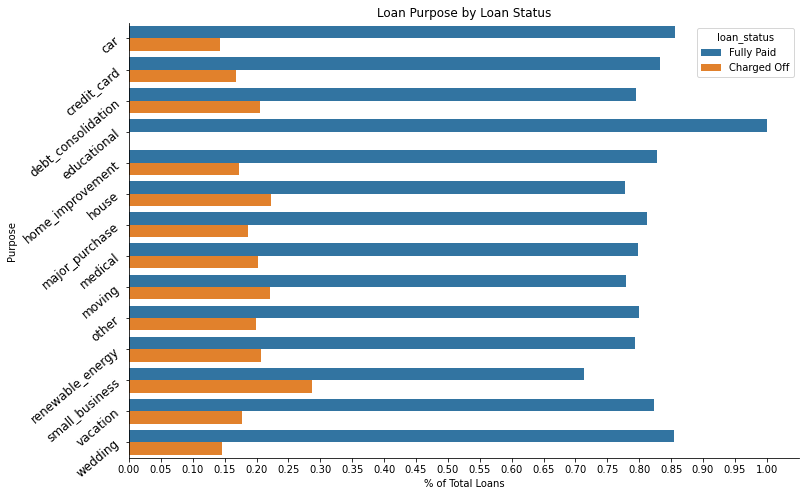

<Figure size 432x288 with 0 Axes>

In [123]:
plt.figure(figsize=(12,8))
sns.barplot(x='value_counts',y='purpose',hue='loan_status',data=comb)
plt.ylabel('Purpose')
plt.xlabel('% of Total Loans')
plt.xticks(np.linspace(0,1,21))
plt.title('Loan Purpose by Loan Status')
plt.yticks(rotation=40,fontsize=12)
sns.despine()
plt.show()
#ax1.set_yticklabels()yticklabels(comb.purpose.values,rotation=35)
plt.tight_layout()
plt.savefig('purpose.png')

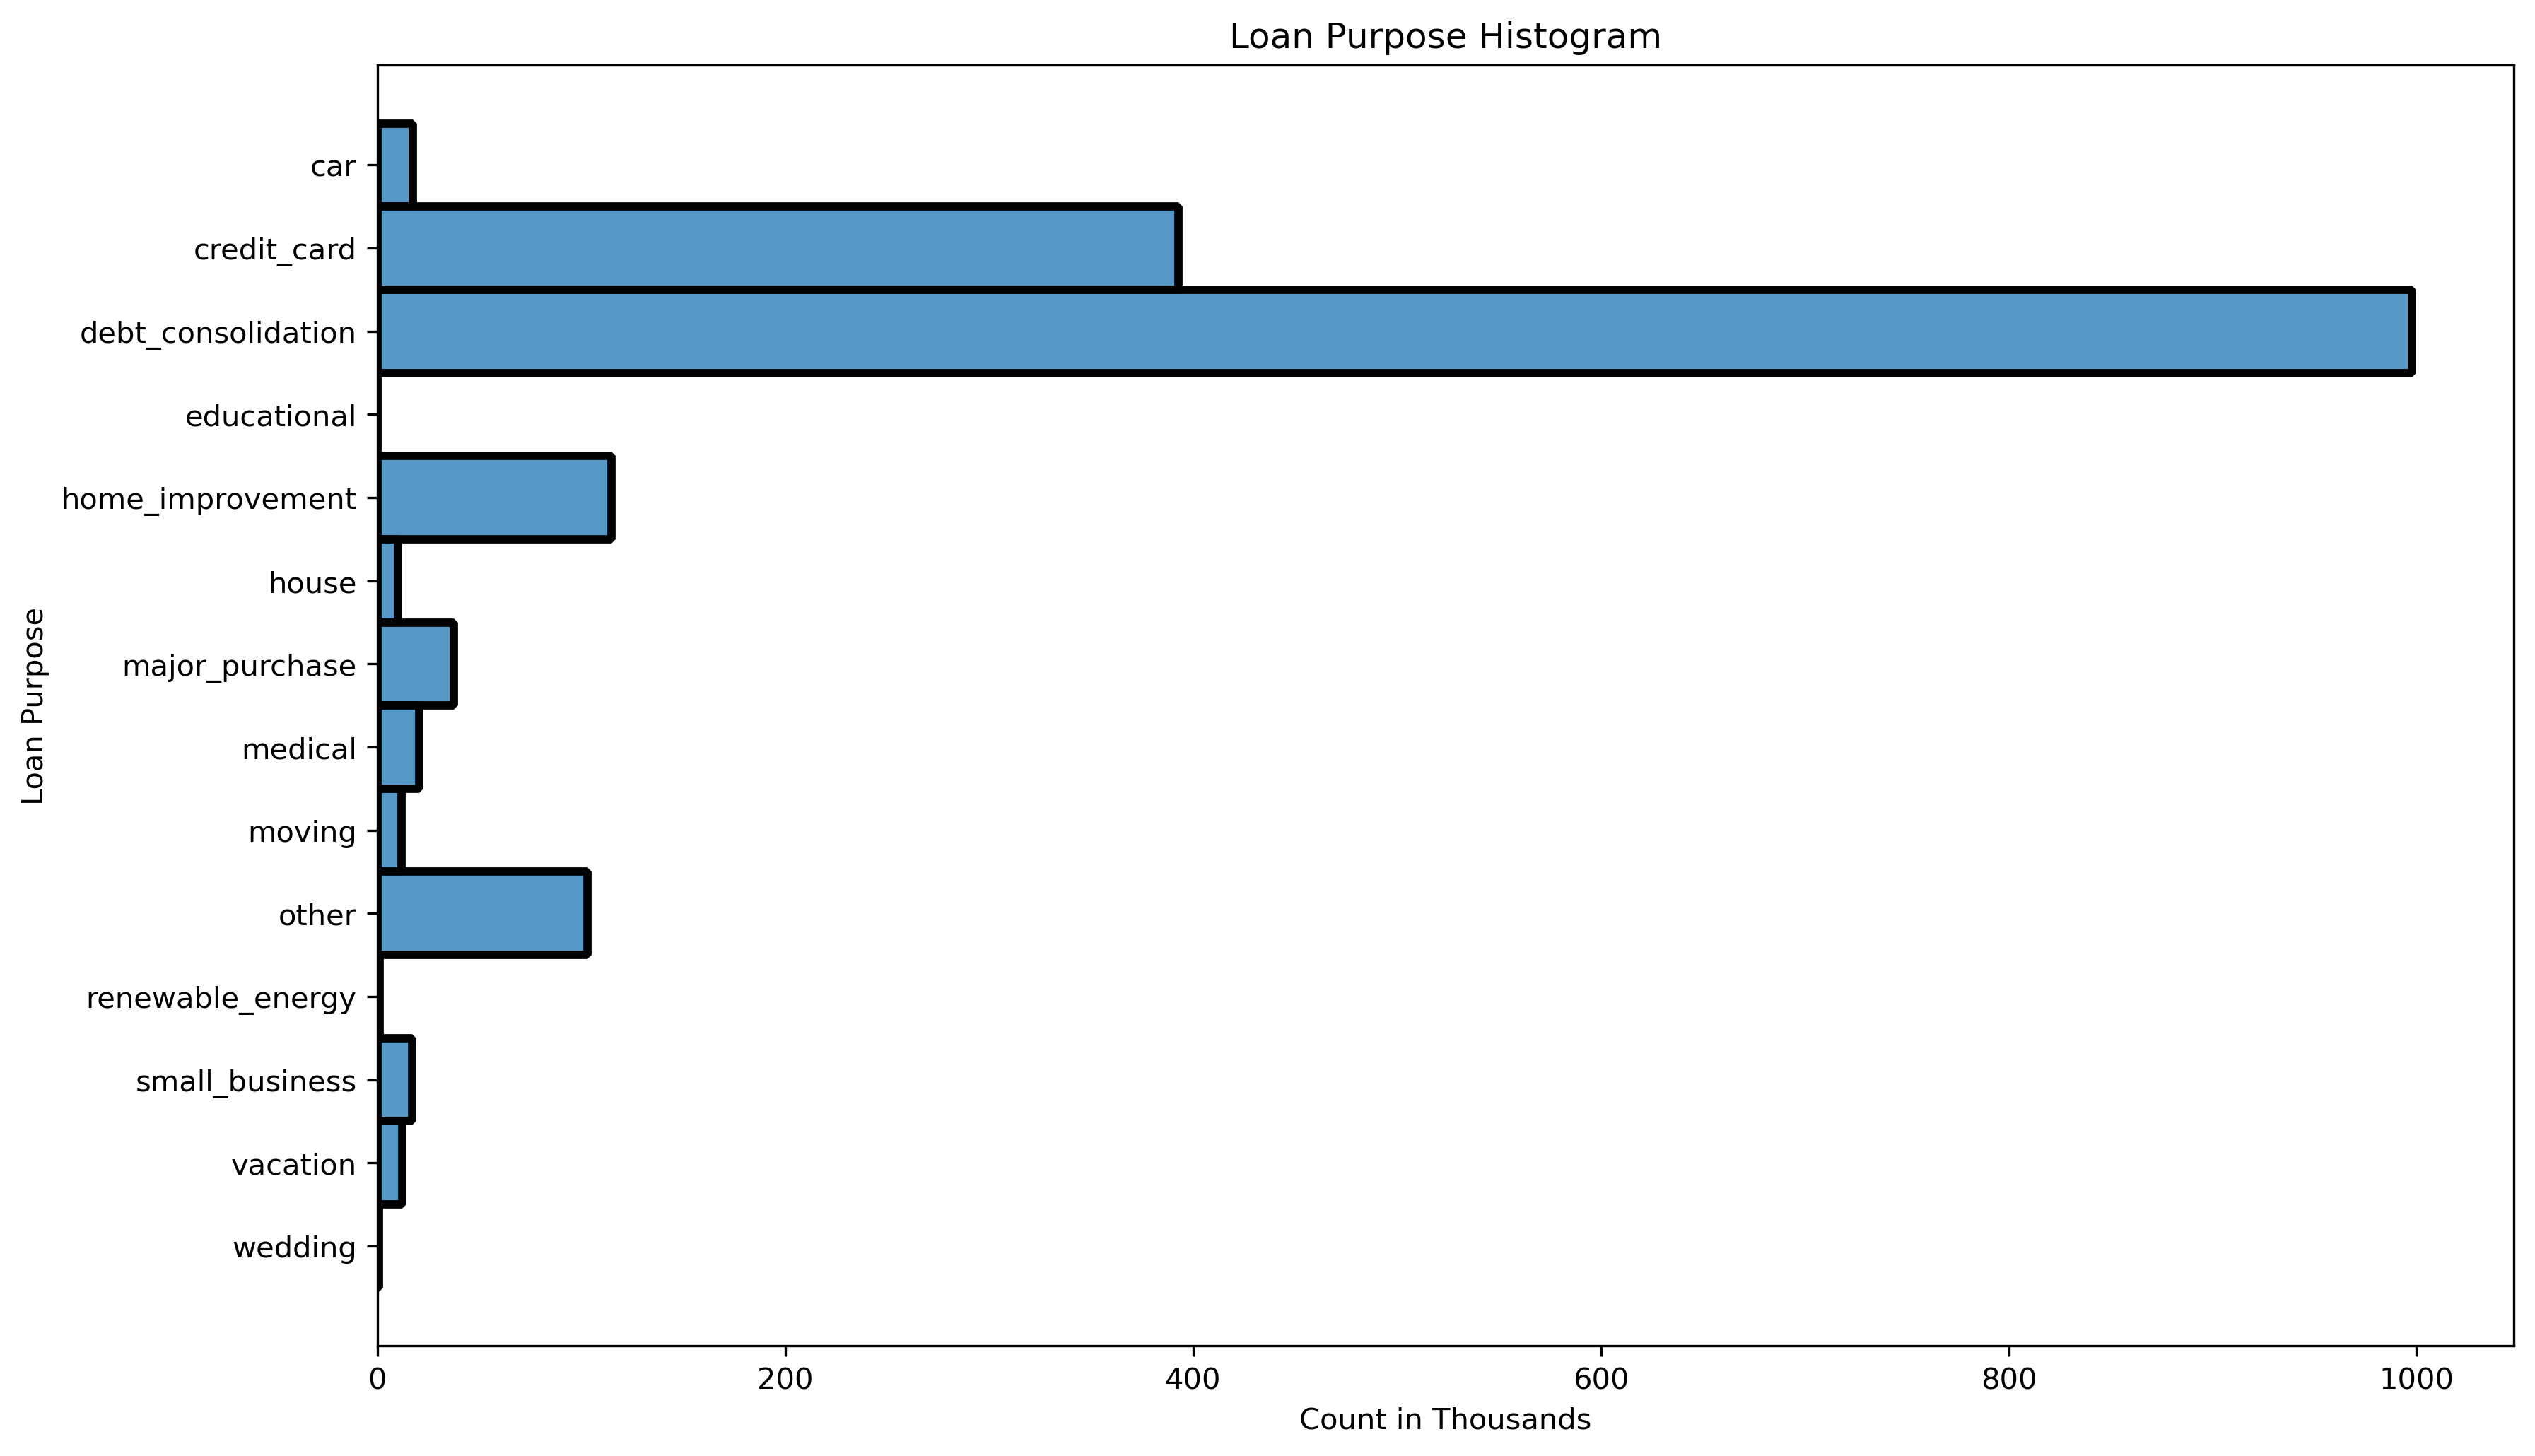

<Figure size 432x288 with 0 Axes>

In [118]:
plt.figure(figsize=(13,8),dpi=300)
sns.histplot(y='purpose', data=df.sort_values('purpose'),bins=(num),line_kws={'mew': .5})
plt.ylabel('Loan Purpose')
plt.xlabel('Count in Thousands')
plt.title('Loan Purpose Histogram')
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(round(x,0)/1000)))
plt.show()
plt.savefig('loan_purpose.png')

Can see that a vast majority of the loans are for debt consolidation followed by credit card

## Initial Status

In [48]:
column_info('initial_list_status')

'The initial listing status of the loan. Possible values are – W, F'

After doing research, W and F here stand for whole or fractional loans but from the perspective of the investor. As the loans are chosen at random they don't influence our data as we can see in our barplots that the percentages for charged off rate and fully paid are the same

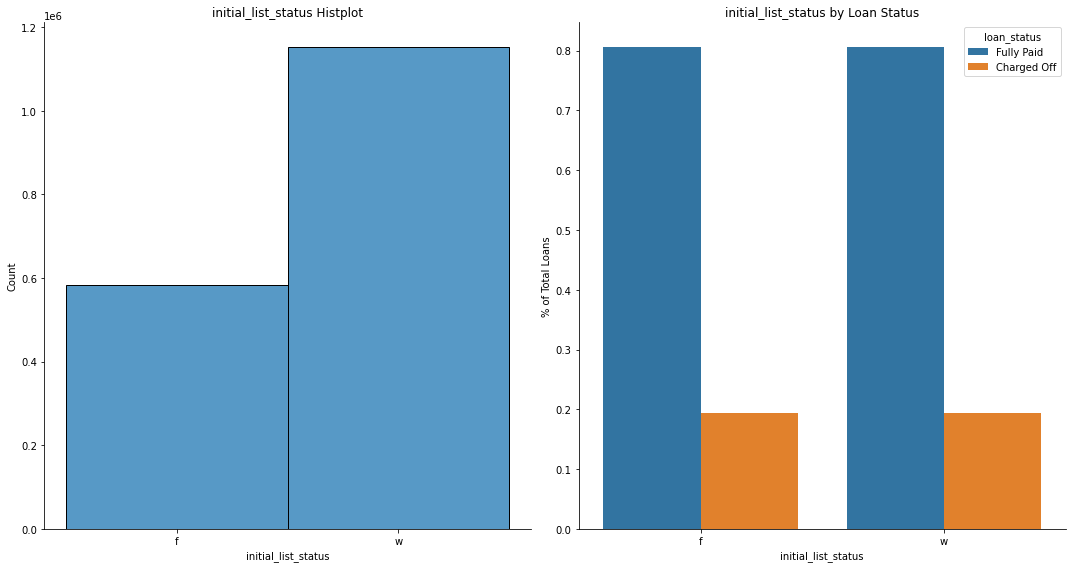

In [49]:
plot_cats('initial_list_status')

In [50]:
features_to_drop.append('initial_list_status')

## States and Zipcodes

In [51]:
column_info('zip_code')

'The first 3 numbers of the zip code provided by the borrower in the loan application.'

In [52]:
df['zip_code'].nunique()

947

In [53]:
column_info('addr_state')

'The state provided by the borrower in the loan application'

In [54]:
#includes washington DC here to explain for 51
df['addr_state'].value_counts()

CA    245034
TX    143643
NY    139854
FL    124679
IL     68114
NJ     62247
PA     58423
OH     57216
GA     56445
NC     48688
VA     47940
MI     45736
AZ     42741
MD     40493
MA     39678
CO     38195
WA     37058
MN     30985
IN     29736
TN     28057
MO     27747
NV     26183
CT     26138
WI     23247
AL     21176
OR     21093
SC     20867
LA     19542
KY     16761
OK     15871
KS     14430
AR     13143
UT     12419
MS      9487
NM      9362
NH      8520
HI      8403
RI      7677
WV      6122
NE      5739
MT      4935
DE      4904
DC      4130
AK      4036
WY      3707
VT      3638
SD      3532
ME      3460
ID      3142
ND      2563
IA         1
Name: addr_state, dtype: int64

As there are too many zipcodes to encode for our models we will use states and group by region

In [55]:
regions = pd.read_excel('data/state_regions.xlsx')

In [56]:
df['region'] = df.addr_state.apply(lambda x: regions.loc[regions['State Code'] == x]['Region'].values[0])

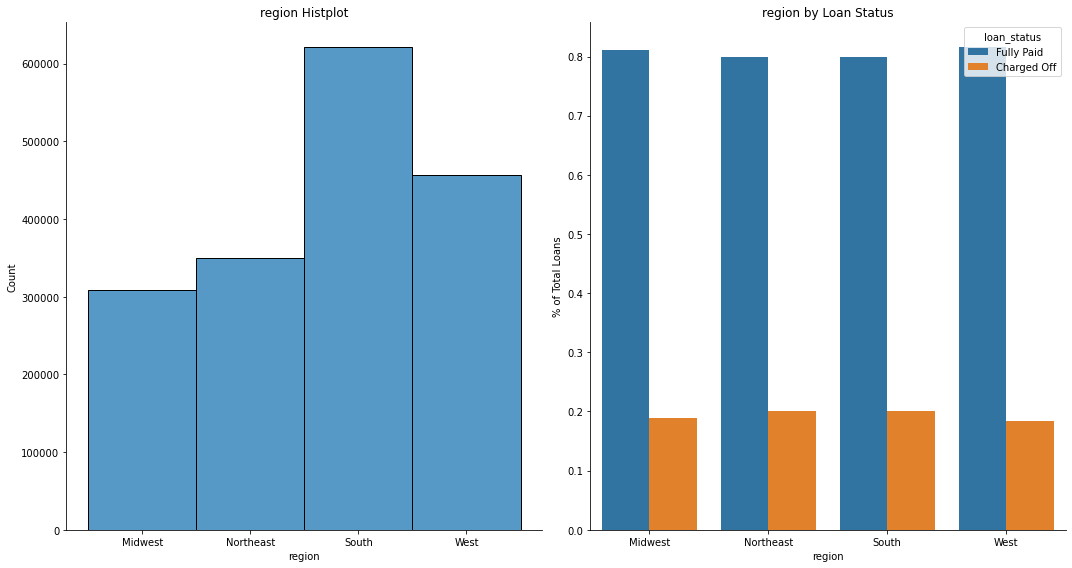

In [57]:
plot_cats('region')

In [58]:
features_to_drop.append('zip_code')

In [59]:
features_to_drop.append('addr_state')

Lending Club loans have a high distribution in the South and the West but these don't seem to affect the performance of the loan grouped by region

## Revol Util

In [60]:
column_info('revol_util')

'Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.'

In [61]:
df.revol_util.value_counts()

0%        7980
48%       3358
57%       3356
59%       3331
58%       3329
          ... 
132.2%       1
180.3%       1
129.4%       1
150.7%       1
123.5%       1
Name: revol_util, Length: 1304, dtype: int64

In [62]:
df.revol_util = df.revol_util.map(lambda x: np.float(x.replace('%','')))

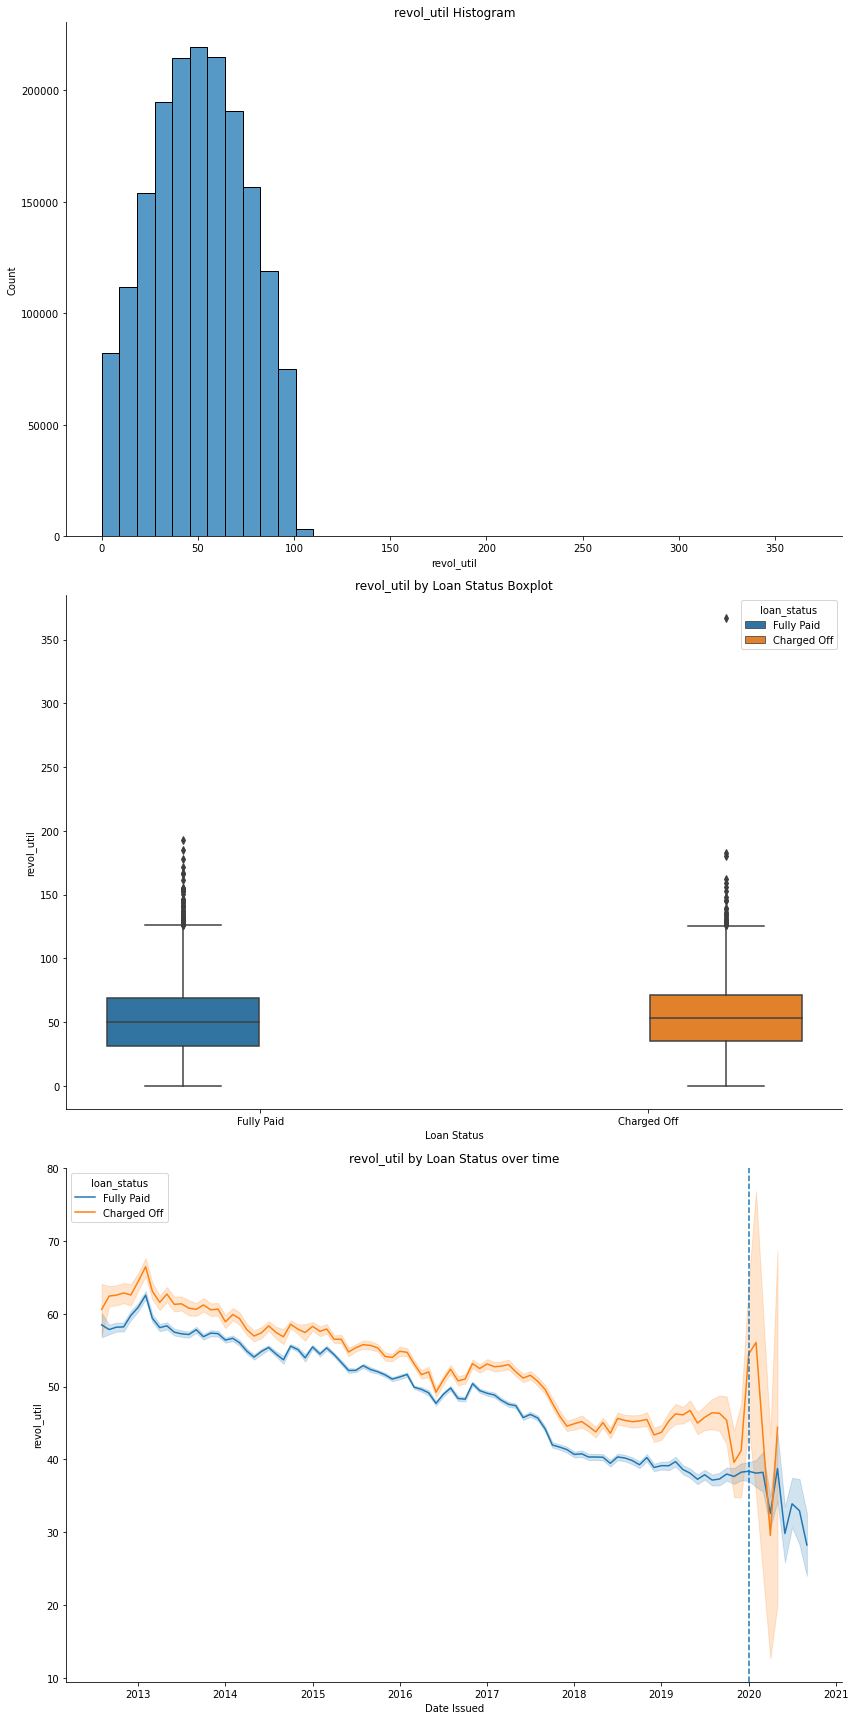

In [63]:
continuous_plot('revol_util')

Main observations here are that charged off loans had higher revovolving balance utilizations but not by much more, this trend holds true over time

In [64]:
df[df.loan_status =='Fully Paid']['revol_util'].describe()

count    1.399842e+06
mean     4.983598e+01
std      2.470900e+01
min      0.000000e+00
25%      3.090000e+01
50%      4.970000e+01
75%      6.890000e+01
max      1.930000e+02
Name: revol_util, dtype: float64

In [65]:
df[df.loan_status =='Charged Off']['revol_util'].describe()

count    337095.000000
mean         52.936573
std          24.029543
min           0.000000
25%          35.200000
50%          53.400000
75%          71.300000
max         366.600000
Name: revol_util, dtype: float64

## Verification Status

In [66]:
column_info('verification_status')

'Indicates if income was verified by LC, not verified, or if the income source was verified'

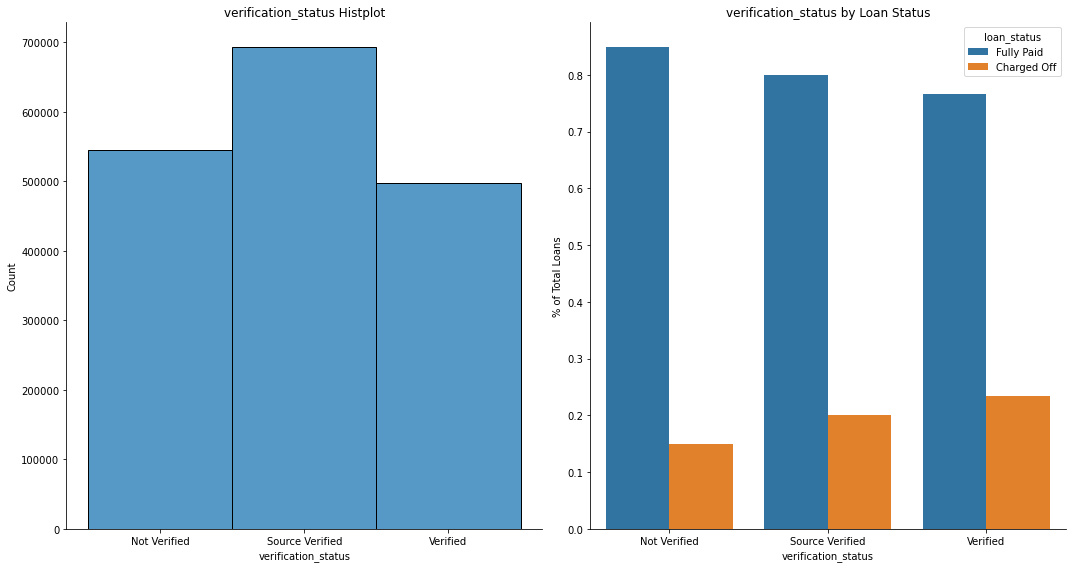

In [67]:
plot_cats('verification_status')

Contrary to logic, verified loans seem to have a higher rate of charge off than non-verified loans

## Application Type

In [68]:
column_info('application_type')

'Indicates whether the loan is an individual application or a joint application with two co-borrowers'

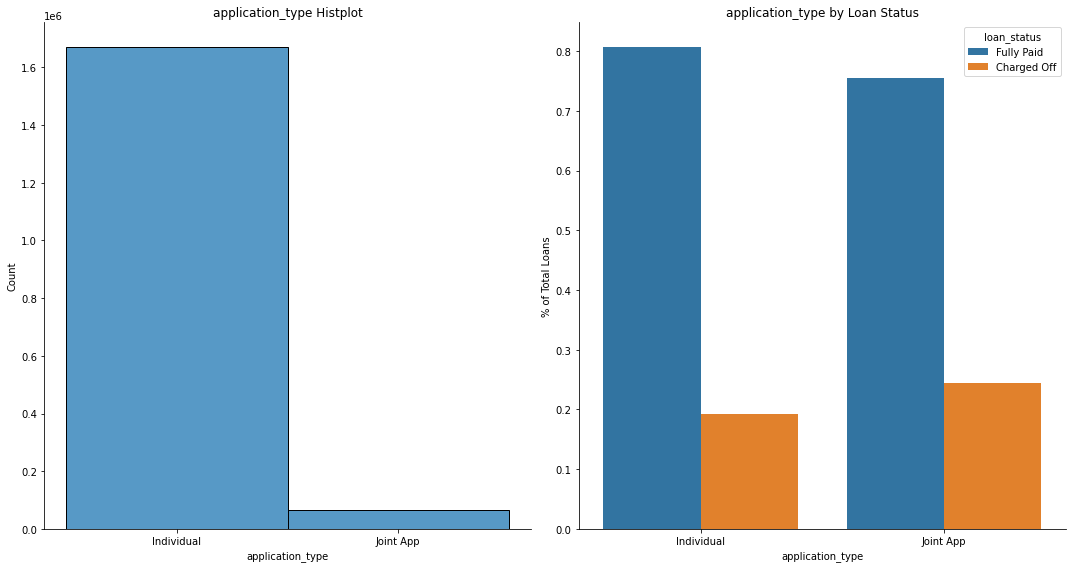

In [69]:
plot_cats('application_type')

Majority of the loans in our data are Individual loans, but joint applications are have higher charge off rates on average

## Interest Rate

In [70]:
column_info('int_rate')

'Interest Rate on the loan'

In [71]:
df.int_rate.value_counts

<bound method IndexOpsMixin.value_counts of 0           10.99%
1           10.99%
2           10.99%
3            7.62%
4           12.85%
            ...   
1736932     23.99%
1736933      7.99%
1736934     16.99%
1736935     11.44%
1736936     25.49%
Name: int_rate, Length: 1736937, dtype: object>

In [72]:
df.int_rate = df.int_rate.map(lambda x: np.float(x.replace('%','')))

In [114]:
df[df.loan_status == "Charged Off"].int_rate.describe()

count    337095.000000
mean         15.664992
std           5.022668
min           5.310000
25%          12.120000
50%          14.990000
75%          18.550000
max          30.990000
Name: int_rate, dtype: float64

In [113]:
df[df.loan_status == "Fully Paid"].int_rate.describe()

count    1.399842e+06
mean     1.256354e+01
std      4.596495e+00
min      5.310000e+00
25%      9.160000e+00
50%      1.199000e+01
75%      1.505000e+01
max      3.099000e+01
Name: int_rate, dtype: float64

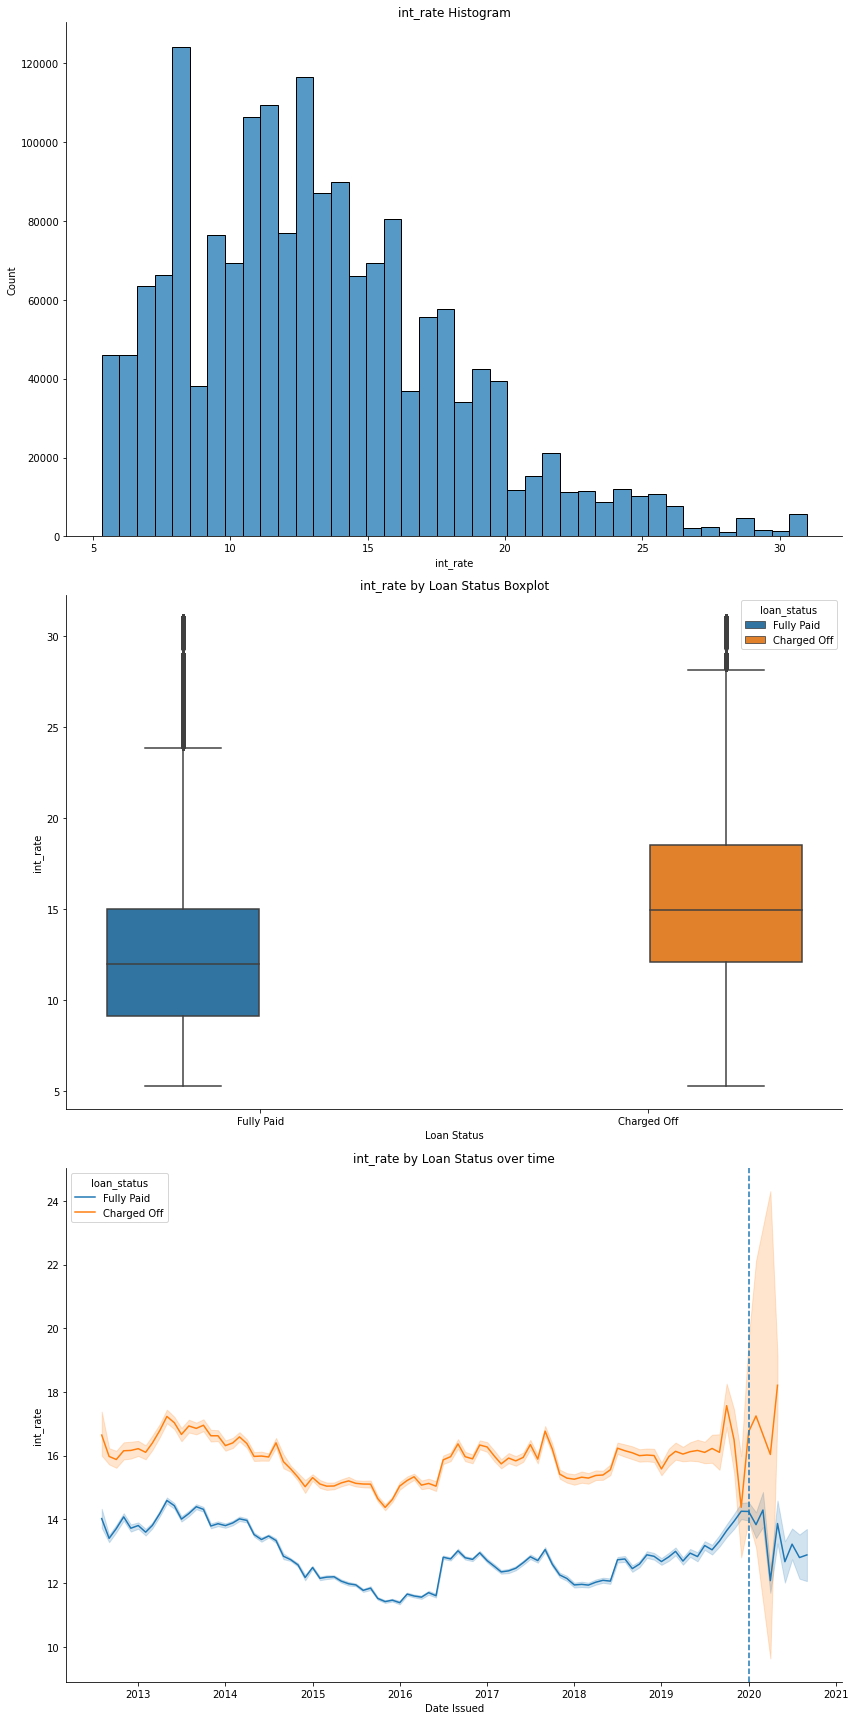

In [110]:
continuous_plot('int_rate')
plt.savefig('interest.png')

A majority of the loans bear an interest rate of 5% - 15%, and as expected higher interest bearing loans have higher charge of likelihoods

## Debt to Income Ratio (DTI)

In [79]:
column_info('dti')

'A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.'

In [80]:
df.dti.describe()

count    1.736937e+06
mean     1.872237e+01
std      1.317191e+01
min     -1.000000e+00
25%      1.196000e+01
50%      1.786000e+01
75%      2.448000e+01
max      9.990000e+02
Name: dti, dtype: float64

In [81]:
df.dti.value_counts()

16.799999     1724
19.200001     1643
17.700001     1593
16.879999     1587
16.270000     1580
              ... 
131.899994       1
758.500000       1
756.500000       1
449.200012       1
201.800003       1
Name: dti, Length: 5199, dtype: int64

In [82]:
#df_cont_z = df[(np.abs(stats.zscore(df[cont_columns]))<4).all(axis=1)]

Upon inpsection, there we some extreme outliers that were skewing our plots so the below plots are having dropped values for DTI outside 3 standard deviations from the mean. This will need to be considered for modeling

In [85]:
from scipy import stats

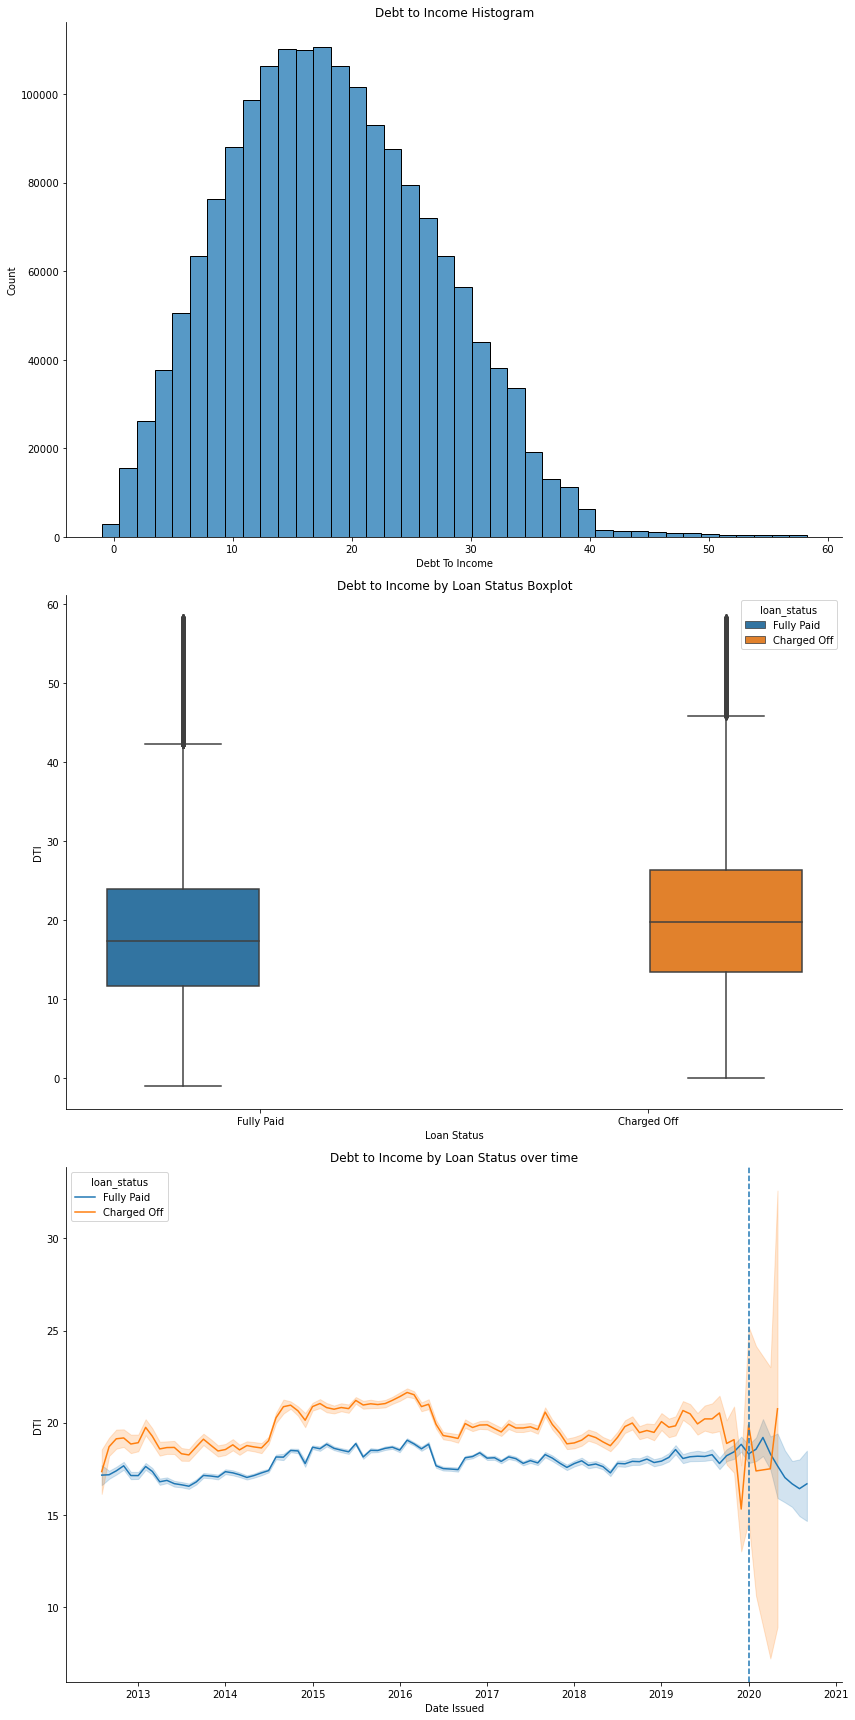

In [115]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,24))
sns.histplot(x='dti',data=df[(np.abs(stats.zscore(df['dti']))<3)],bins=40,ax=ax1)
ax1.set_xlabel("Debt To Income")
ax1.set_ylabel('Count')
ax1.set_title('Debt to Income Histogram')

sns.despine()
sns.boxplot(x='loan_status' ,y='dti',hue='loan_status',data=df[(np.abs(stats.zscore(df['dti']))<3)],ax=ax2,)
ax2.set_xlabel('Loan Status')
ax2.set_ylabel("DTI")
ax2.set_title('Debt to Income by Loan Status Boxplot')

sns.lineplot(x='issue_d' ,y='dti',hue='loan_status',data=df[(np.abs(stats.zscore(df['dti']))<3)],ax=ax3)
ax3.set_xlabel('Date Issued')
ax3.set_ylabel("DTI")
ax3.set_title('Debt to Income by Loan Status over time')
ax3.axvline(x='2020',linestyle='--')
plt.tight_layout()
plt.savefig('dti.png')

Most loans are between 10-20 DTI and there is a slightly higher Charged Off rate for higher DTI's with fully paid loans at 18% vs 20% for charged off loans

In [87]:
temp = df[(np.abs(stats.zscore(df['dti']))<3)]

In [88]:
temp[temp.loan_status =='Fully Paid']['dti'].describe()

count    1.396292e+06
mean     1.803052e+01
std      8.577942e+00
min     -1.000000e+00
25%      1.164000e+01
50%      1.740000e+01
75%      2.390000e+01
max      5.822000e+01
Name: dti, dtype: float64

In [89]:
temp[temp.loan_status =='Charged Off']['dti'].describe()

count    335658.000000
mean         20.024944
std           8.981527
min           0.000000
25%          13.410000
50%          19.719999
75%          26.400000
max          58.220001
Name: dti, dtype: float64

## Public Record Bankruptcies

In [90]:
column_info('pub_rec_bankruptcies')

'Number of public record bankruptcies'

In [91]:
df[(np.abs(stats.zscore(df['pub_rec_bankruptcies']))<3)]

,id,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,...,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag,average_fico,region
0,10129454,12000.0,36 months,10.99,392.799988,B,B2,4,RENT,60000.0,...,100.000000,0.0,0.0,7137.0,18100.0,0.0,N,N,722.0,South
1,10149488,4800.0,36 months,10.99,157.100006,B,B2,2,MORTGAGE,39600.0,...,100.000000,0.0,0.0,4136.0,25700.0,0.0,N,N,757.0,South
2,10149342,27060.0,36 months,10.99,885.500000,B,B2,10,OWN,55000.0,...,100.000000,0.0,0.0,70186.0,35700.0,33054.0,N,N,732.0,Midwest
3,10148122,12000.0,36 months,7.62,374.000000,A,A3,3,MORTGAGE,96500.0,...,100.000000,0.0,0.0,46738.0,14800.0,53404.0,N,N,707.0,South
4,10129477,14000.0,36 months,12.85,470.799988,B,B4,4,RENT,88000.0,...,78.599998,1.0,0.0,17672.0,3900.0,27340.0,N,N,672.0,South
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1736932,102556443,24000.0,60 months,23.99,690.500000,E,E2,1,RENT,107000.0,...,87.500000,1.0,1.0,60812.0,28200.0,64422.0,N,N,672.0,West
1736933,102653304,10000.0,36 months,7.99,313.200012,A,A5,10,MORTGAGE,65000.0,...,92.599998,0.0,0.0,55863.0,34800.0,70203.0,N,N,727.0,Northeast
1736934,102628603,10050.0,36 months,16.99,358.200012,D,D1,8,RENT,37000.0,...,95.199997,0.0,0.0,14300.0,9000.0,0.0,N,N,707.0,South
1736935,102196576,6000.0,36 months,11.44,197.800003,B,B4,5,RENT,41000.0,...,94.400002,0.0,0.0,26201.0,8100.0,34076.0,N,N,672.0,Northeast


In [92]:
df.pub_rec_bankruptcies

0          0.0
1          0.0
2          0.0
3          0.0
4          1.0
          ... 
1736932    1.0
1736933    0.0
1736934    0.0
1736935    0.0
1736936    0.0
Name: pub_rec_bankruptcies, Length: 1736937, dtype: float32

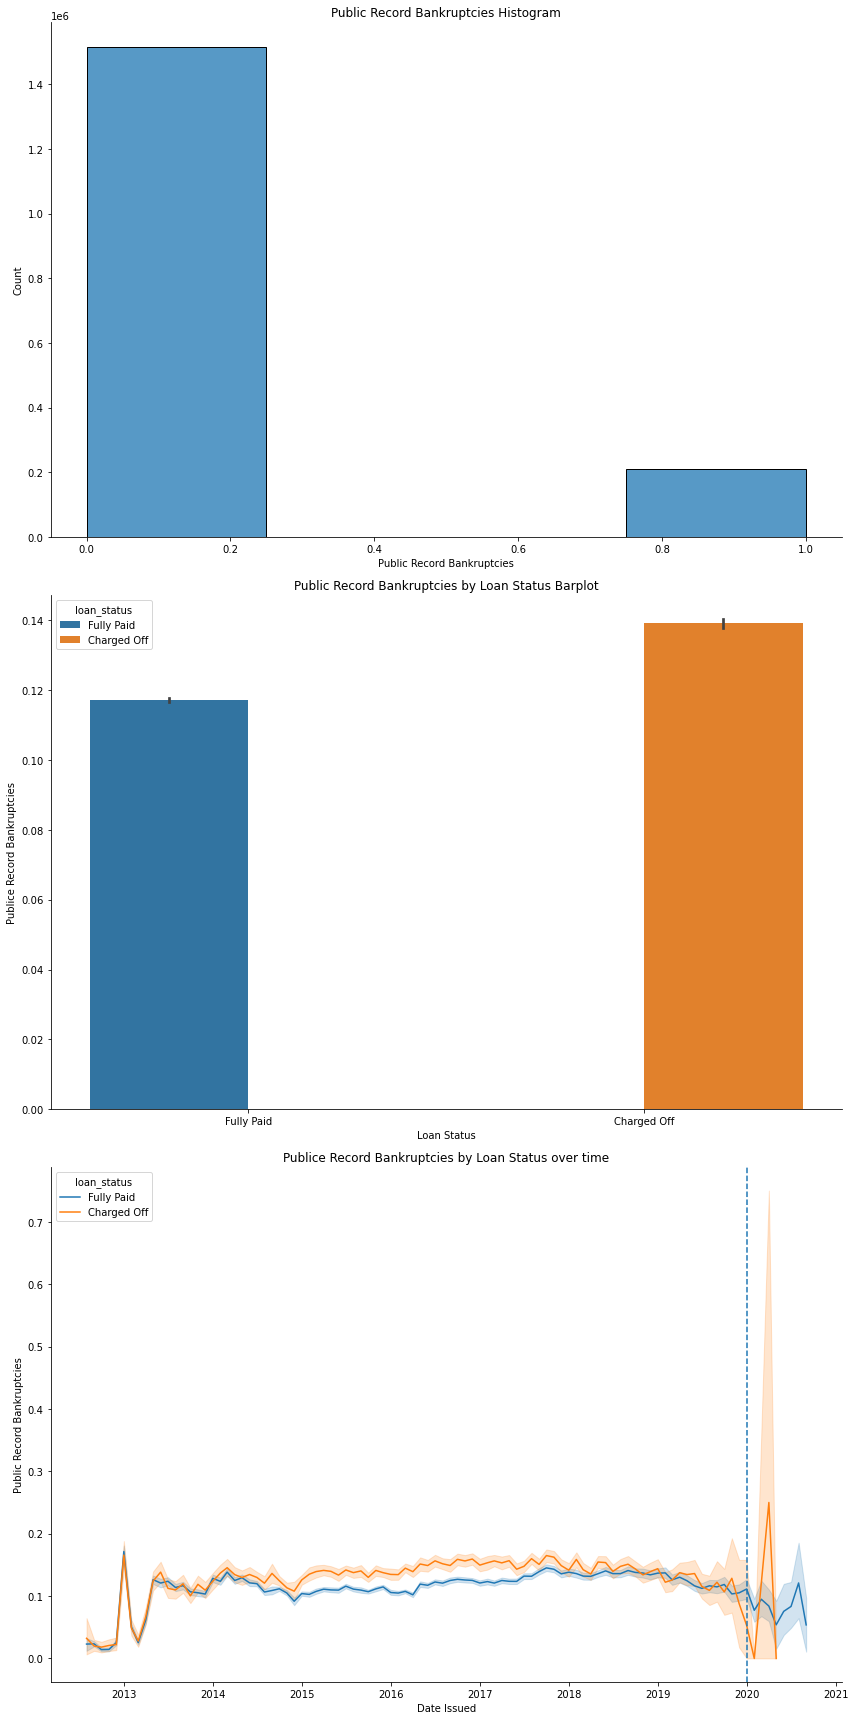

In [93]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,24))
sns.histplot(x='pub_rec_bankruptcies',data=df[(np.abs(stats.zscore(df['pub_rec_bankruptcies']))<3)],bins=4,ax=ax1)
ax1.set_xlabel("Public Record Bankruptcies")
ax1.set_ylabel('Count')
ax1.set_title('Public Record Bankruptcies Histogram')

sns.despine()
sns.barplot(x='loan_status' ,y='pub_rec_bankruptcies',hue='loan_status',data=df[(np.abs(stats.zscore(df['pub_rec_bankruptcies']))<3)],ax=ax2,)
ax2.set_xlabel('Loan Status')
ax2.set_ylabel('Publice Record Bankruptcies')
ax2.set_title('Public Record Bankruptcies by Loan Status Barplot')

sns.lineplot(x='issue_d' ,y='pub_rec_bankruptcies',hue='loan_status',data=df[(np.abs(stats.zscore(df['pub_rec_bankruptcies']))<3)],ax=ax3)
ax3.set_xlabel('Date Issued')
ax3.set_ylabel("Public Record Bankruptcies")
ax3.set_title('Publice Record Bankruptcies by Loan Status over time')
ax3.axvline(x='2020',linestyle='--')
plt.tight_layout()

There are around 200k loans that have a public bankruptcy record. The higher average pub rec bankruptcies have a small relationship with higher charge offs

## Total Accounts

In [94]:
column_info('total_acc')

"The total number of credit lines currently in the borrower's credit file"

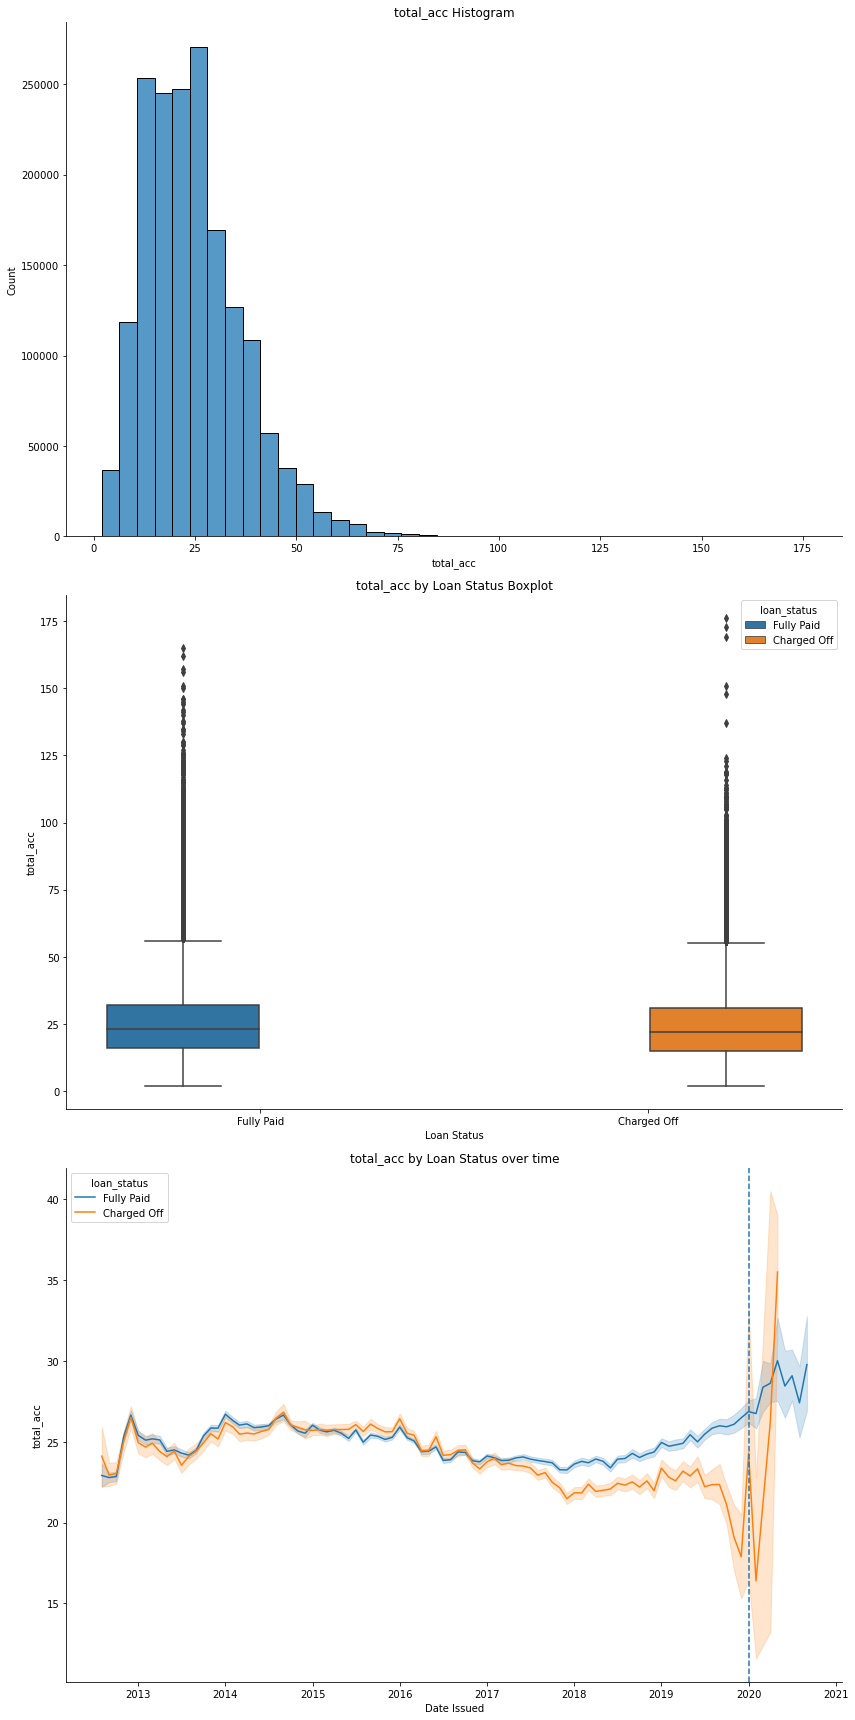

In [95]:
continuous_plot('total_acc')

No clear difference in charge off rates by total accounts

## Annual Income

In [96]:
column_info('annual_inc')

'The self-reported annual income provided by the borrower during registration.'

In [97]:
df[(np.abs(stats.zscore(df['annual_inc']))<3)]['annual_inc'].describe()

count    1.732761e+06
mean     7.611088e+04
std      4.542821e+04
min      0.000000e+00
25%      4.670000e+04
50%      6.500000e+04
75%      9.200000e+04
max      4.400000e+05
Name: annual_inc, dtype: float64

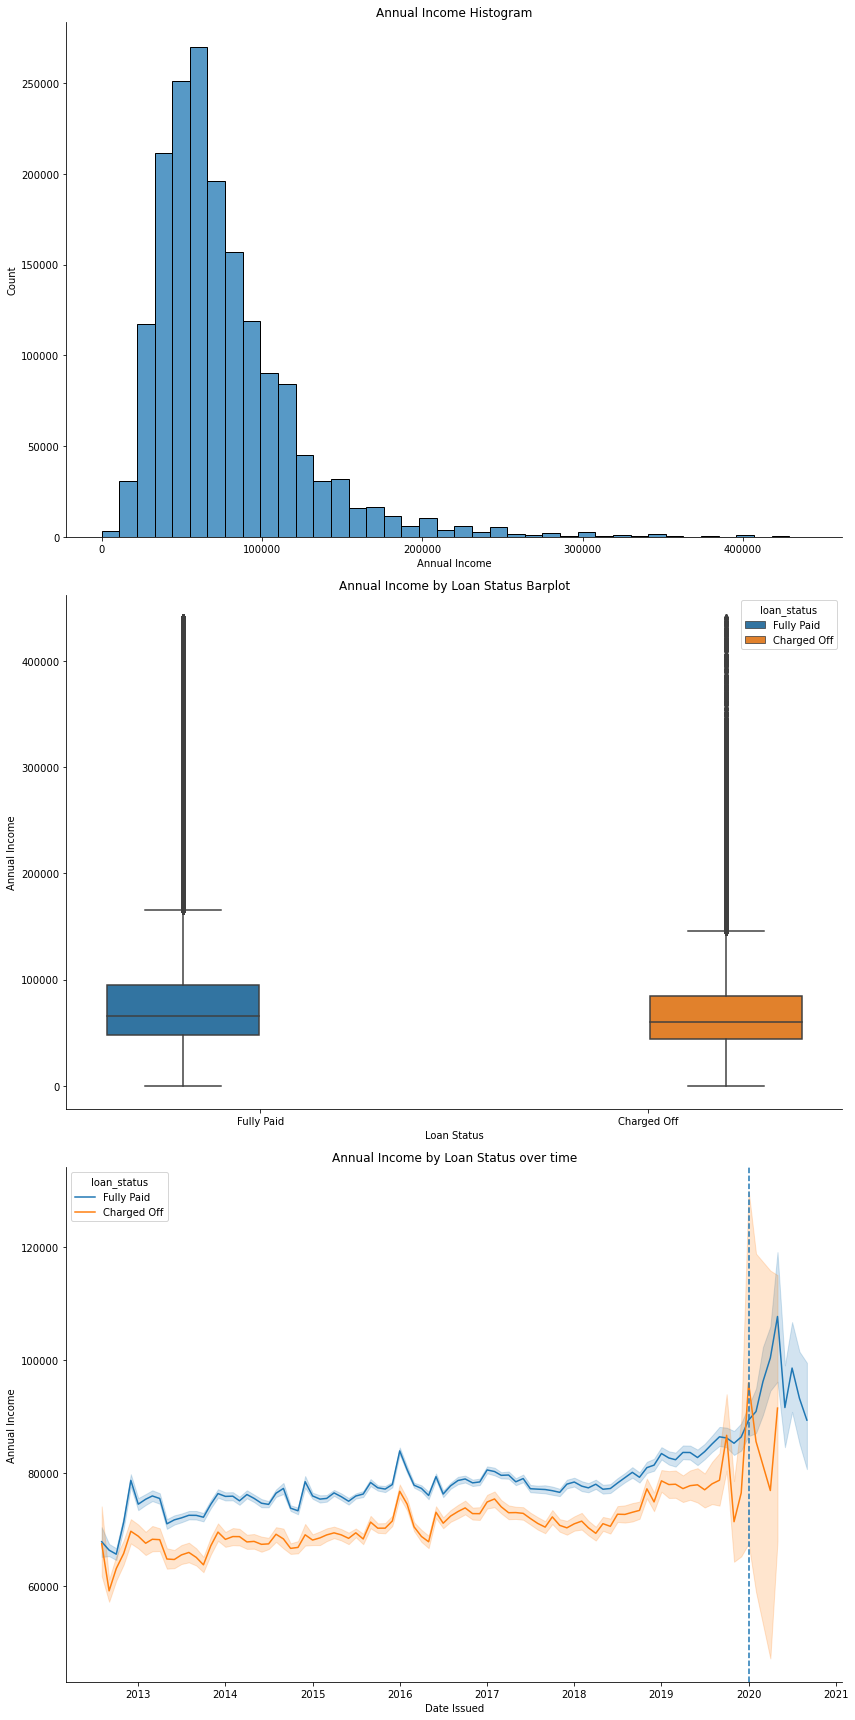

In [116]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,24))
sns.histplot(x='annual_inc',data=df[(np.abs(stats.zscore(df['annual_inc']))<3)],bins=40,ax=ax1)
ax1.set_xlabel("Annual Income")
ax1.set_ylabel('Count')
ax1.set_title('Annual Income Histogram')

sns.despine()
sns.boxplot(x='loan_status' ,y='annual_inc',hue='loan_status',
            data=df[(np.abs(stats.zscore(df['annual_inc']))<3)],ax=ax2,)
ax2.set_xlabel('Loan Status')
ax2.set_ylabel('Annual Income')
ax2.set_title('Annual Income by Loan Status Barplot')

sns.lineplot(x='issue_d' ,y='annual_inc',hue='loan_status',
             data=df[(np.abs(stats.zscore(df['annual_inc']))<3)])
ax3.set_xlabel('Date Issued')
ax3.set_ylabel("Annual Income")
ax3.set_title('Annual Income by Loan Status over time')
ax3.axvline(x='2020',linestyle='--')
plt.tight_layout()
plt.savefig('annual_inc.png')

In [99]:
temp = df[(np.abs(stats.zscore(df['annual_inc']))<3)]

In [100]:
temp[temp.loan_status =='Fully Paid']['annual_inc'].describe()

count    1.396161e+06
mean     7.737917e+04
std      4.623032e+04
min      0.000000e+00
25%      4.800000e+04
50%      6.600000e+04
75%      9.500000e+04
max      4.400000e+05
Name: annual_inc, dtype: float64

In [101]:
temp[temp.loan_status =='Charged Off']['annual_inc'].describe()

count    336600.000000
mean      70850.304688
std       41526.242188
min          20.000000
25%       44400.000000
50%       60092.500000
75%       85000.000000
max      440000.000000
Name: annual_inc, dtype: float64

Can see a normal distribution of incomes (after dropping outliers for 3 std devs) with median income around 70k

Charged off loans had 7k less income

## Total Received Late Fee

In [126]:
df.total_rec_late_fee.describe()

count    1.736937e+06
mean     2.033143e+00
std      1.415953e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.599000e+03
Name: total_rec_late_fee, dtype: float64

In [127]:
column_info('total_rec_late_fee')

'Late fees received to date'

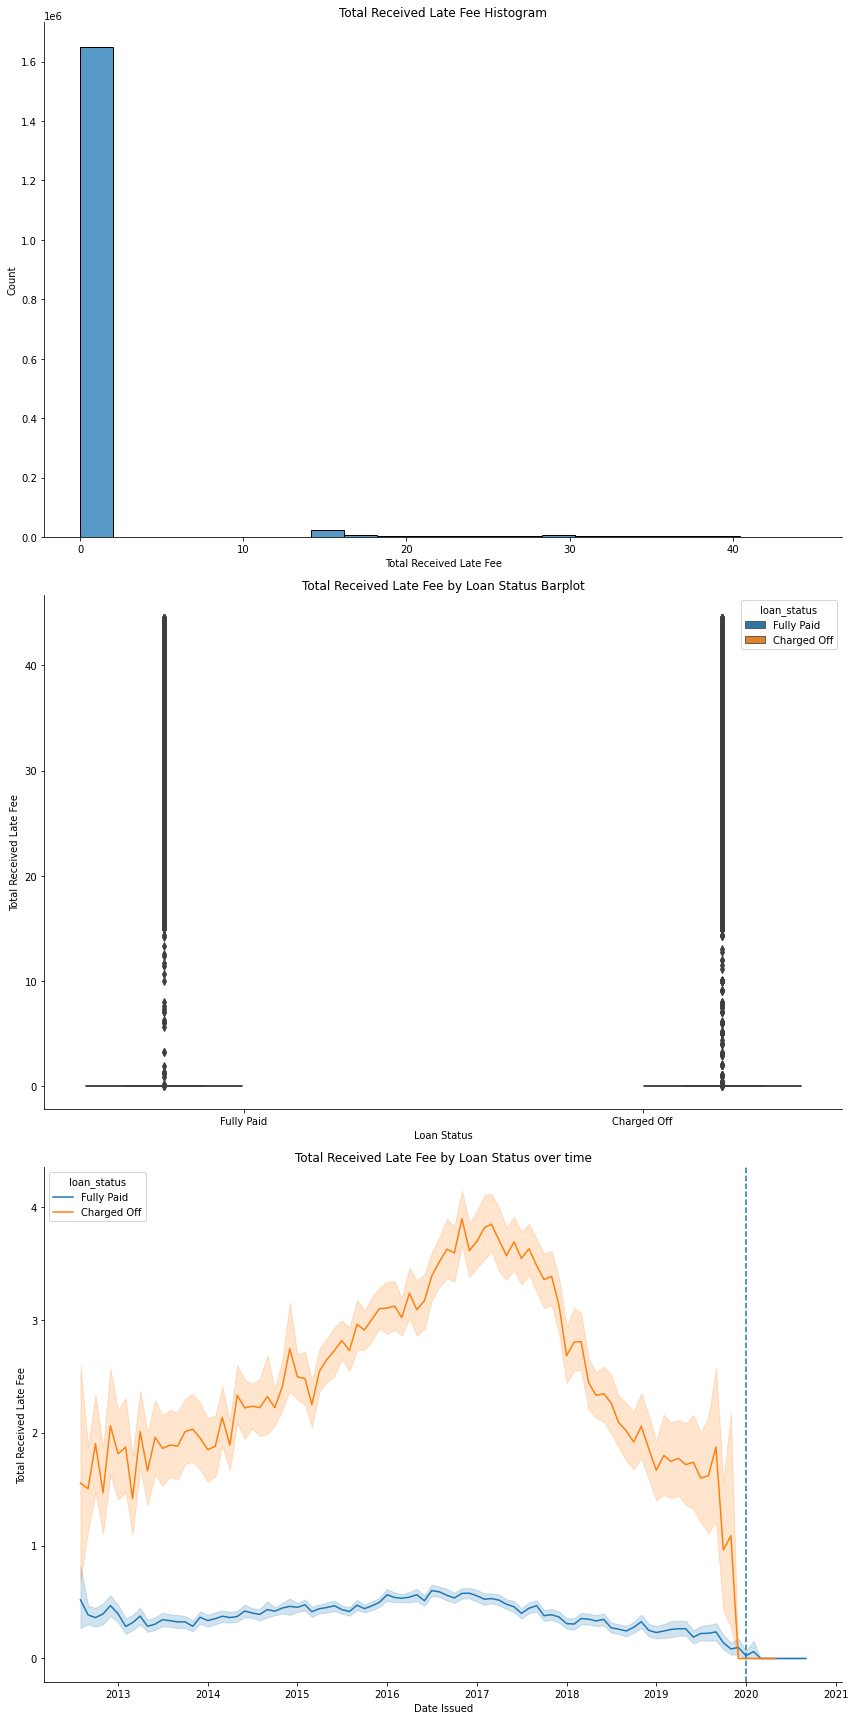

In [134]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,24))
sns.histplot(x='total_rec_late_fee',data=df[(np.abs(stats.zscore(df['total_rec_late_fee']))<3)],bins='auto',ax=ax1)
ax1.set_xlabel("Total Received Late Fee")
ax1.set_ylabel('Count')
ax1.set_title('Total Received Late Fee Histogram')

sns.despine()
sns.boxplot(x='loan_status' ,y='total_rec_late_fee',hue='loan_status',
            data=df[(np.abs(stats.zscore(df['total_rec_late_fee']))<3)],ax=ax2,)
ax2.set_xlabel('Loan Status')
ax2.set_ylabel('Total Received Late Fee')
ax2.set_title('Total Received Late Fee by Loan Status Barplot')

sns.lineplot(x='issue_d' ,y='total_rec_late_fee',hue='loan_status',
             data=df[(np.abs(stats.zscore(df['total_rec_late_fee']))<3)])
ax3.set_xlabel('Date Issued')
ax3.set_ylabel("Total Received Late Fee")
ax3.set_title('Total Received Late Fee by Loan Status over time')
ax3.axvline(x='2020',linestyle='--')
plt.tight_layout()
plt.savefig('late_fee.png')


In [131]:
late = df[(np.abs(stats.zscore(df['total_rec_late_fee']))<3)]

In [132]:
late[late.loan_status == 'Fully Paid']['total_rec_late_fee'].describe()

count    1.389853e+06
mean     4.325036e-01
std      3.335348e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.450000e+01
Name: total_rec_late_fee, dtype: float64

In [138]:
1.389853e+06* 4.325036e-01

601116.4259708

In [135]:
late[late.loan_status == 'Charged Off']['total_rec_late_fee'].describe()

count    324778.000000
mean          2.804207
std           8.159093
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          44.500000
Name: total_rec_late_fee, dtype: float64

In [137]:
324778/(1.389853e+06+324778)

0.18941568185807908

In [139]:
 324778.000000* 2.804207

910744.7410459999

## Recoveries

In [143]:
column_info('recoveries')

'post charge off gross recovery'

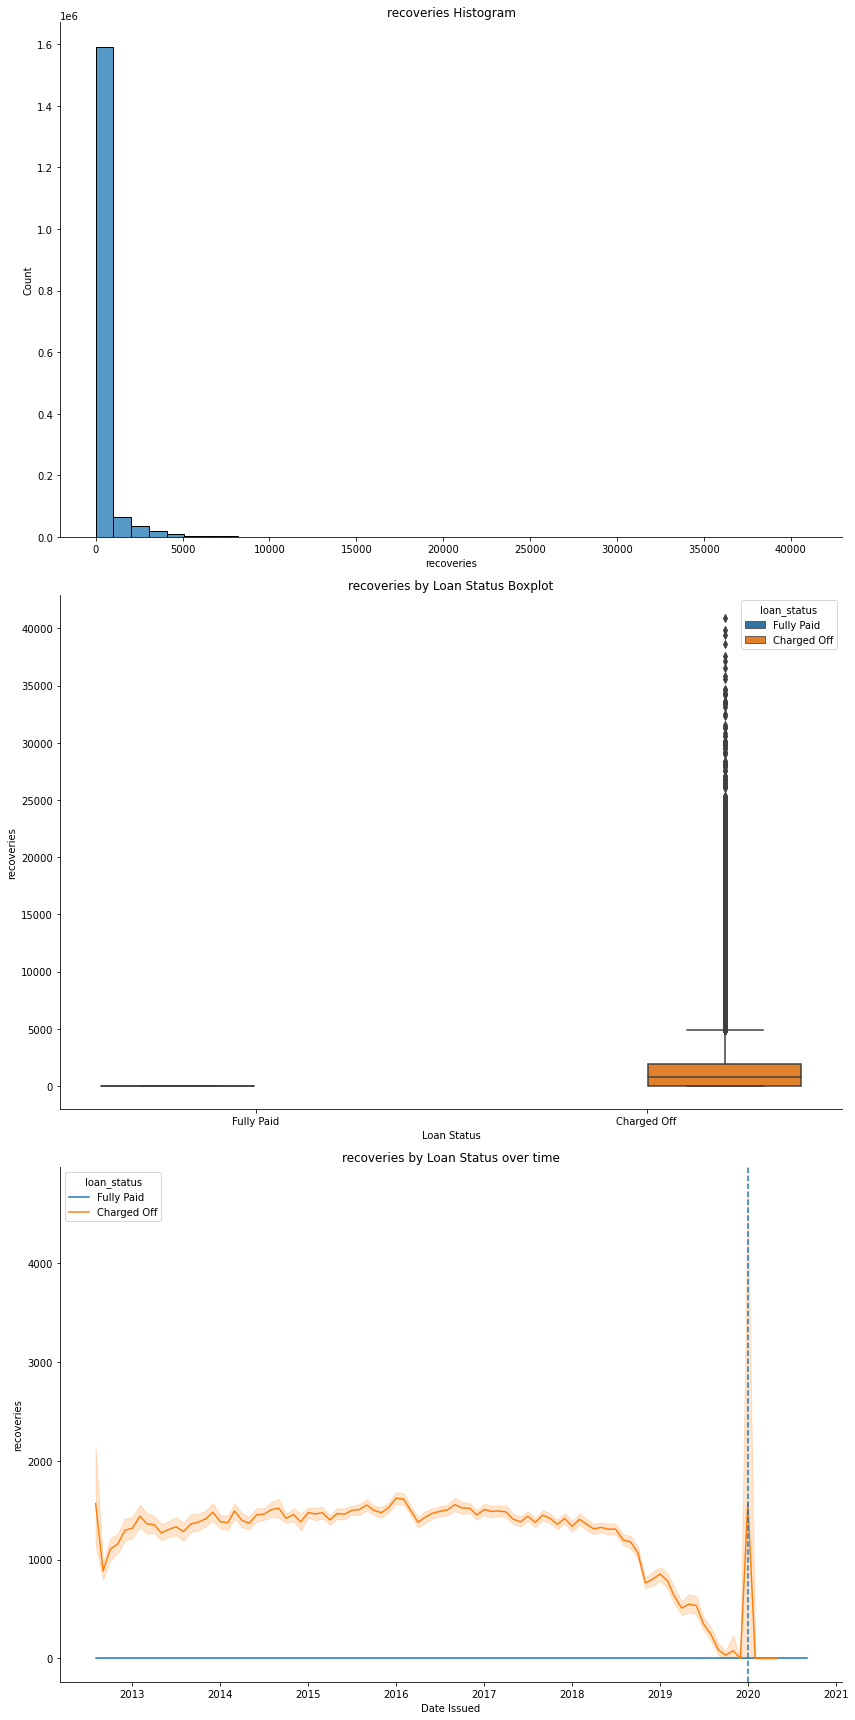

In [142]:
continuous_plot('recoveries')
plt.savefig('recoveries.png')

## Inquiry in the last 6 months

In [145]:
df.inq_last_6mths.value_counts()

0.0    1032003
1.0     464220
2.0     162402
3.0      56828
4.0      15306
5.0       5315
6.0        859
7.0          3
8.0          1
Name: inq_last_6mths, dtype: int64

In [144]:
column_info('inq_last_6mths')

'The number of inquiries in past 6 months (excluding auto and mortgage inquiries)'

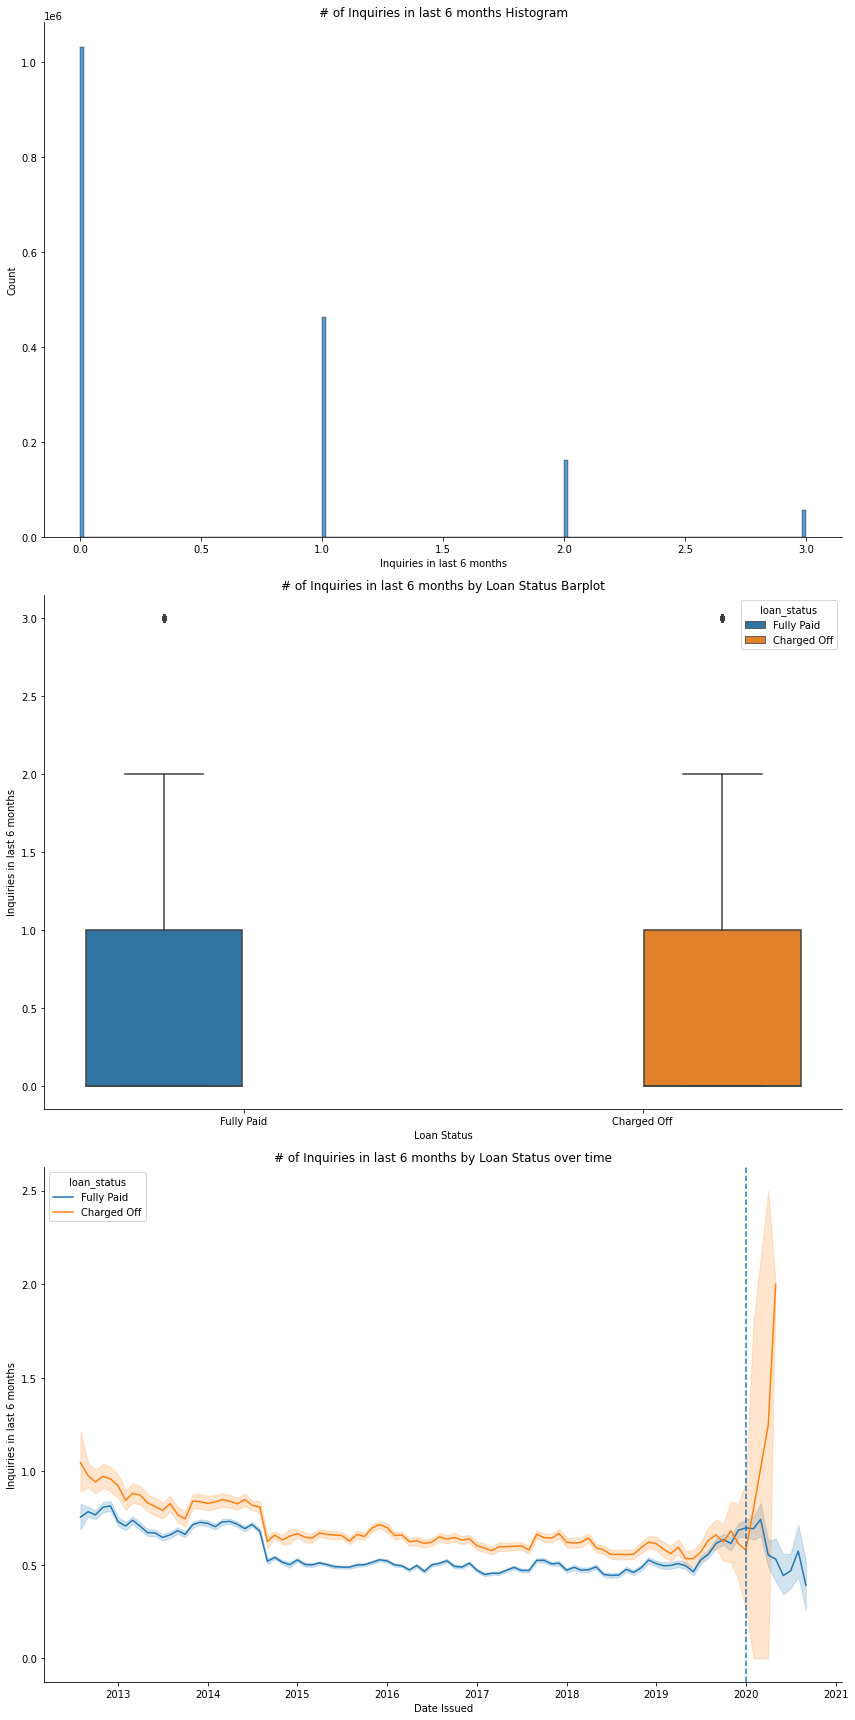

In [150]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,24))
sns.histplot(x='inq_last_6mths',data=df[(np.abs(stats.zscore(df['inq_last_6mths']))<3)],bins='auto',ax=ax1)
ax1.set_xlabel("Inquiries in last 6 months")
ax1.set_ylabel('Count')
ax1.set_title('# of Inquiries in last 6 months Histogram')

sns.despine()
sns.boxplot(x='loan_status' ,y='inq_last_6mths',hue='loan_status',
            data=df[(np.abs(stats.zscore(df['inq_last_6mths']))<3)],ax=ax2,)
ax2.set_xlabel('Loan Status')
ax2.set_ylabel('Inquiries in last 6 months')
ax2.set_title('# of Inquiries in last 6 months by Loan Status Barplot')

sns.lineplot(x='issue_d' ,y='inq_last_6mths',hue='loan_status',
             data=df[(np.abs(stats.zscore(df['inq_last_6mths']))<3)])
ax3.set_xlabel('Date Issued')
ax3.set_ylabel("Inquiries in last 6 months")
ax3.set_title('# of Inquiries in last 6 months by Loan Status over time')
ax3.axvline(x='2020',linestyle='--')
plt.tight_layout()



In [147]:
inq = df[(np.abs(stats.zscore(df['inq_last_6mths']))<3)]

In [148]:
inq[inq.loan_status == 'Fully Paid']['inq_last_6mths'].describe()

count    1.384187e+06
mean     5.345470e-01
std      7.806073e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      3.000000e+00
Name: inq_last_6mths, dtype: float64

In [149]:
inq[inq.loan_status == 'Charged Off']['inq_last_6mths'].describe()

count    331266.000000
mean          0.662896
std           0.852488
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           3.000000
Name: inq_last_6mths, dtype: float64

## Number of accounts opened in last 12 months

In [151]:
column_info('num_tl_op_past_12m')

'Number of accounts opened in past 12 months'

In [152]:
df.num_tl_op_past_12m.value_counts()

1.0     432793
2.0     388818
0.0     303474
3.0     276608
4.0     163867
5.0      82404
6.0      40983
7.0      22180
8.0      11334
9.0       6320
10.0      3389
11.0      1906
12.0      1124
13.0       636
14.0       403
15.0       236
16.0       168
17.0       108
18.0        51
19.0        38
20.0        29
21.0        20
23.0        13
22.0         9
25.0         7
24.0         5
28.0         4
26.0         4
30.0         2
27.0         1
32.0         1
29.0         1
31.0         1
Name: num_tl_op_past_12m, dtype: int64

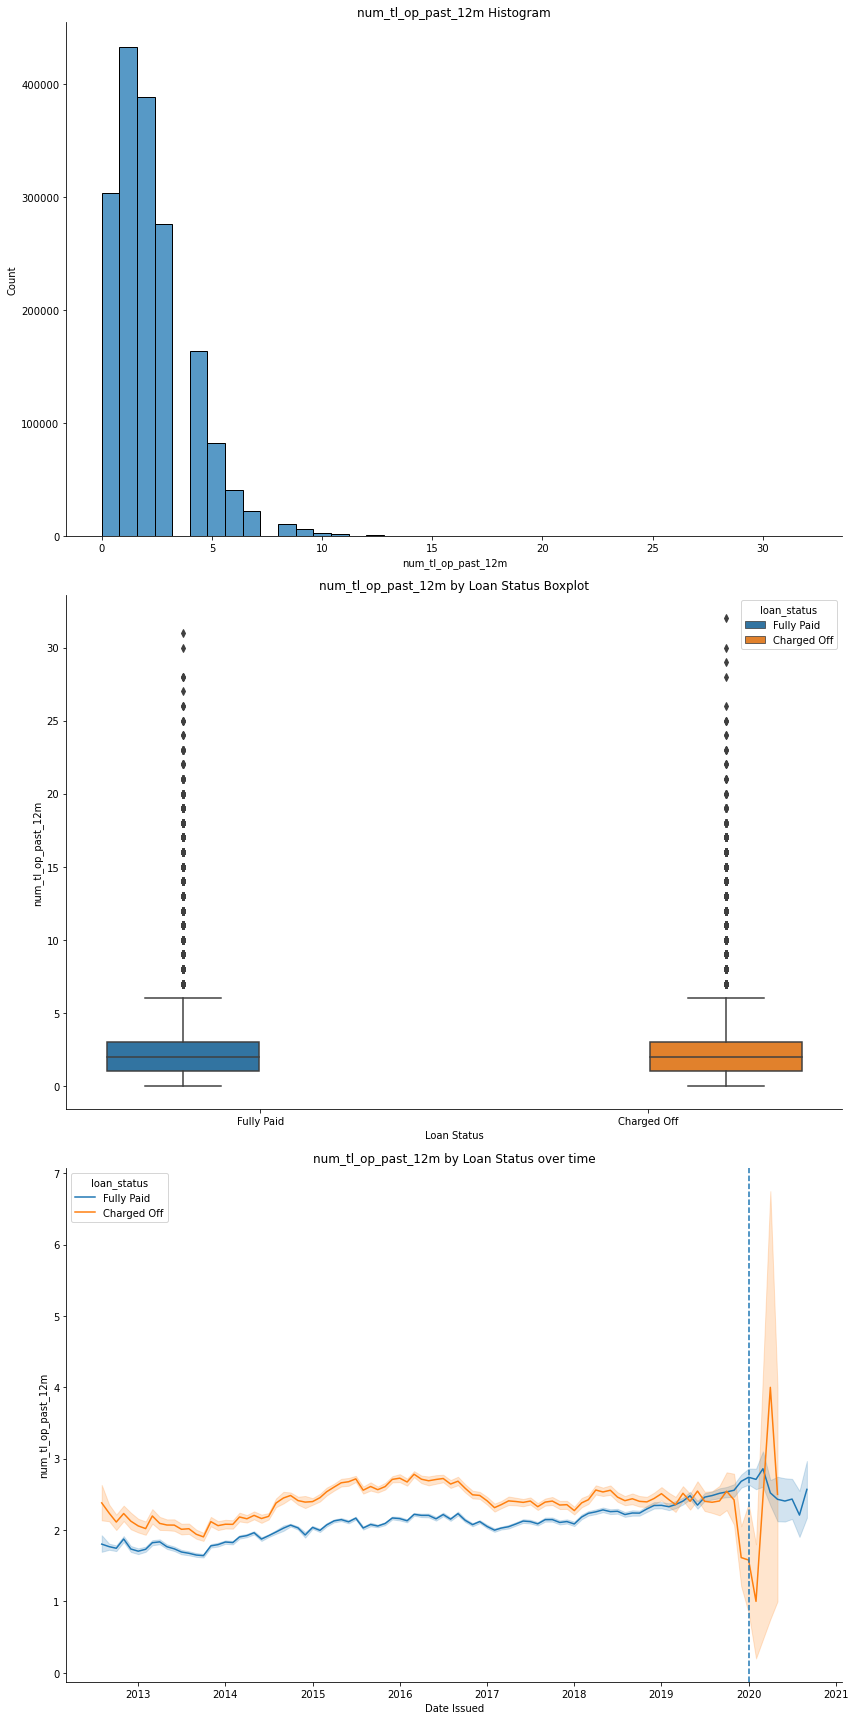

In [153]:
continuous_plot('num_tl_op_past_12m')